In [48]:
import polars as pl
import pandas as pd
pd.set_option("display.max_rows", None)
import requests
import csv
import time
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ESTRUTURA PROPOSTA:


###    1. Introdução

###    2. Project Understanding

###    3. Data Understanding
#####  3.1. Descrição
#####  3.2. EDA
#####  3.3. Correlações
#####  3.4. Qualidade dos dados

###    4. Data Preparation
#####  4.1. Limpeza
#####  4.2. Transformações
#####  4.3. Feature Engineering

###    5. Modeling
#####  5.1. Clustering
#####  5.2. Modelos de previsão
#####  5.3. Normalização

###    6. Evaluation

###    7. Conclusion

###    8. References

# 3. Data Understanding
 
O dataset utilizado corresponde ao registo contínuo de consumos energéticos de vários edifícios municipais da Maia, recolhidos através de sistemas de telemetria. As medições são efetuadas em intervalos regulares de 15 minutos, permitindo caracterizar com grande detalhe os padrões de utilização energética ao longo do tempo.
 ## 3.1 Descrição do Dataset
Cada registo do Dataset, incluí:
 - Código do local (CPE);
 - Timestamp da medição (tstamp);
 - DadosDeConsumo (kW/h);
 - Potência Ativa (kW/h);
 - Potência Reativa Indutiva (VAR);
 - Potência Reativa Capacitiva (VAR).



In [49]:
df = pl.read_csv(
    "consumo15m_11_2025.csv",
    null_values="NULL"
)

df

shape: (5_940_182, 6)
┌────────────────────────┬────────────┬────────────────┬───────────┬───────────────┬───────────────┐
│ CPE                    ┆ tstamp     ┆ DadosdeConsumo ┆ PotActiva ┆ PotReactIndut ┆ PotReactCapac │
│ ---                    ┆ ---        ┆ ---            ┆ ---       ┆ ---           ┆ ---           │
│ str                    ┆ str        ┆ str            ┆ f64       ┆ str           ┆ str           │
╞════════════════════════╪════════════╪════════════════╪═══════════╪═══════════════╪═══════════════╡
│ PT0002000089069203YG   ┆ 2022-12-31 ┆ null           ┆ 0.296     ┆ null          ┆ null          │
│                        ┆ 00:15:00   ┆                ┆           ┆               ┆               │
│ PT0002000089069203YG   ┆ 2022-12-31 ┆ null           ┆ 0.292     ┆ null          ┆ null          │
│                        ┆ 00:30:00   ┆                ┆           ┆               ┆               │
│ PT0002000089069203YG   ┆ 2022-12-31 ┆ null           ┆ 0.284     ┆ null          ┆ null          │
│                        ┆ 00:45:00   ┆                ┆           ┆               ┆               │
│ PT0002000089069203YG   ┆ 2022-12-31 ┆ null           ┆ 0.28      ┆ null          ┆ null          │
│                        ┆ 01:00:00   ┆                ┆           ┆               ┆               │
│ PT0002000089069203YG   ┆ 2022-12-31 ┆ null           ┆ 0.272     ┆ null          ┆ null          │
│                        ┆ 01:15:00   ┆                ┆           ┆               ┆               │
│ …                      ┆ …          ┆ …              ┆ …         ┆ …             ┆ …             │
│ PT0002000110607652SB   ┆ 2025-04-30 ┆ null           ┆ 3.0       ┆ 1.000         ┆ 0.000         │
│                        ┆ 23:00:00   ┆                ┆           ┆               ┆               │
│ PT0002000110607652SB   ┆ 2025-04-30 ┆ null           ┆ 3.0       ┆ 2.000         ┆ 0.000         │
│                        ┆ 23:15:00   ┆                ┆           ┆               ┆               │
│ PT0002000110607652SB   ┆ 2025-04-30 ┆ null           ┆ 3.0       ┆ 1.000         ┆ 0.000         │
│                        ┆ 23:30:00   ┆                ┆           ┆               ┆               │
│ PT0002000110607652SB   ┆ 2025-04-30 ┆ null           ┆ 2.0       ┆ 1.000         ┆ 0.000         │
│                        ┆ 23:45:00   ┆                ┆           ┆               ┆               │
│ PT0002000110607652SB   ┆ 2025-05-01 ┆ null           ┆ 3.0       ┆ 1.000         ┆ 0.000         │
│                        ┆ 00:00:00   ┆                ┆           ┆               ┆               │
└────────────────────────┴────────────┴────────────────┴───────────┴───────────────┴───────────────┘

Foi também possivel obter do site D4Maia / BaZe os edificios associados aos CPEs através do seguinte código.

In [50]:
CPE_LIST_URL = "https://baze.cm-maia.pt/BaZe/api/cpelist.php"
SUMAC_URL = "http://baze2.cm-maia.pt/D4CMMaia/api/sumac.php?cpe={cpe}&ano=2023&cate=BTE"

def obter_cpes():
    resp = requests.get(CPE_LIST_URL)
    resp.raise_for_status()
    return resp.json()

def obter_descricao(cpe):
    url = SUMAC_URL.format(cpe=cpe)
    resp = requests.get(url)
    resp.raise_for_status()
    data = resp.json()

    return data.get("metadata", {}).get("Descrição", "--")

def gerar_csv(ficheiro="cpes_descricao.csv"):
    cpes = obter_cpes()
    print(f"Encontrados {len(cpes)} CPEs.\n")

    with open(ficheiro, "w", encoding="utf-8", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["CPE", "Descrição"])

        for cpe in cpes:
            descricao = obter_descricao(cpe)
            writer.writerow([cpe, descricao])
            print(f"{cpe} → {descricao}")
            time.sleep(0.2)  # poupa servidor

    print(f"\nCSV gerado: {ficheiro}")

In [51]:
gerar_csv()

Encontrados 125 CPEs.

PT0002000032935564NG → PT0092
PT0002000032936306KX → PT0195
PT0002000032942455NH → EB1/JI de Gueifães - EDIFÍCIO 2
PT0002000032959511HP → --
PT0002000032966446CC → EB1 PADRÃO
PT0002000032968749YT → EB1/JI ARCOS
PT0002000032969229AC → EB1/JI FERREIRÓ
PT0002000032976997LZ → EB1/JI PROZELA
PT0002000032990792KD → EB1/JI PEDRAS RUBRAS - EDIFÍCIO NOVO
PT0002000032993611ME → Centro Escolar GUARDA - EDIFÍCIO ANTIGO
PT0002000033016394FN → CONSERVATÓRIO MÚSICA Maia
PT0002000033026194LZ → EB1/JI SEARA - EDIFÍCIO ANTIGO
PT0002000033039837ZH → --
PT0002000033070538SZ → OFICINAS ESPAÇO Municipal
PT0002000033074177NL → MERCADO da Maia
PT0002000033074862LZ → Centro Escolar de Mandim
PT0002000033085062AW → JARDIMCOOPE - SOLIDERIEDADE SOCIAL / 2122782359
PT0002000033094187PL → OFICINAS GERAIS - GABINETES
PT0002000033164293CK → --
PT0002000033171958DG → CPCJ Maia
PT0002000033173831KZ → PT0369
PT0002000033174184JE → PT0355
PT0002000033180983XJ → PT0001
PT0002000033181018NW → PT0004


In [53]:
df_desc = pl.read_csv("cpes_descricao.csv")
df_cpe = df["CPE"].unique(maintain_order=True).clone().to_frame()
df_compare = df_cpe.join(df_desc, on="CPE", how="left")
df_compare

shape: (91, 2)
┌──────────────────────┬─────────────────────────────────┐
│ CPE                  ┆ Descrição                       │
│ ---                  ┆ ---                             │
│ str                  ┆ str                             │
╞══════════════════════╪═════════════════════════════════╡
│ PT0002000089069203YG ┆ POSTO TURISMO Maia              │
│ PT0002000068856906VS ┆ Quinta dos Cónegos              │
│ PT0002000078441876HB ┆ Torre do Lidador (e/ou Paços d… │
│ PT0002000081997398TD ┆ Parque Central da Maia          │
│ PT0002000100113293JT ┆ Complexo Municipal das Piscina… │
│ …                    ┆ …                               │
│ PT0002000033039837ZH ┆ --                              │
│ PT0002000114685657JR ┆ --                              │
│ PT0002000079901964CJ ┆ PT0618                          │
│ PT0002000131605602FL ┆ AG PT0676                       │
│ PT0002000033085062AW ┆ JARDIMCOOPE - SOLIDERIEDADE SO… │
└──────────────────────┴─────────────────────────────────┘


# 3.2 Limpeza Inicial e Conversão de Tipos
 Antes de proceder à análise, é essencial garantir:
 - conversão do timestamp para formato datetime;
 - conversão das colunas numéricas para float;
 - eliminação/tratamento dos valores "NULL".
 
Estas etapas são fundamentais, pois garantem a consistência do dataset e permitem realizar operações estatísticas e temporais de forma correta. Após esta limpeza, os dados ficam prontos para uma exploração detalhada e fiável.

In [3]:
df = df.with_columns(
    pl.col("tstamp").str.to_datetime("%Y-%m-%d %H:%M:%S")
)

df = df.with_columns([
    pl.col("DadosdeConsumo").cast(pl.Float64),
    pl.col("PotReactIndut").cast(pl.Float64),
    pl.col("PotReactCapac").cast(pl.Float64),
])

df.dtypes

[String,
 Datetime(time_unit='us', time_zone=None),
 Float64,
 Float64,
 Float64,
 Float64]

# 3.3 Análise Descritiva e Visualização

Nesta fase, são calculadas as principais métricas estatísticas, como média, desvio padrão, valores mínimos e máximos. Esta análise, complementada por histogramas, permite uma compreensão inicial da distribuição e da escala das variáveis, sendo fundamental para detetar anomalias, como outliers ou valores inesperados.

In [4]:
df.describe().transpose(include_header=True, header_name="statistic", column_names="statistic")

shape: (6, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ count     ┆ null_coun ┆ mean      ┆ … ┆ 25%       ┆ 50%       ┆ 75%       ┆ max      │
│ ---       ┆ ---       ┆ t         ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ str       ┆ str       ┆ ---       ┆ str       ┆   ┆ str       ┆ str       ┆ str       ┆ str      │
│           ┆           ┆ str       ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ CPE       ┆ 5940182   ┆ 0         ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ PT000200 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 02019361 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 09ME     │
│ tstamp    ┆ 5940182   ┆ 0         ┆ 2024-04-1 ┆ … ┆ 2023-09-2 ┆ 2024-05-1 ┆ 2024-11-0 ┆ 2025-05- │
│           ┆           ┆           ┆ 5 22:32:2 ┆   ┆ 8         ┆ 5         ┆ 8         ┆ 01       │
│           ┆           ┆           ┆ 6.636113  ┆   ┆ 05:00:00  ┆ 14:00:00  ┆ 01:00:00  ┆ 00:00:00 │
│ DadosdeCo ┆ 0.0       ┆ 5940182.0 ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ nsumo     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ PotActiva ┆ 5940182.0 ┆ 0.0       ┆ 8.0939661 ┆ … ┆ 0.12      ┆ 2.0       ┆ 7.0       ┆ 574.0    │
│           ┆           ┆           ┆ 59622719  ┆   ┆           ┆           ┆           ┆          │
│ PotReactI ┆ 3668710.0 ┆ 2271472.0 ┆ 1.7153228 ┆ … ┆ 0.0       ┆ 0.0       ┆ 2.0       ┆ 177.0    │
│ ndut      ┆           ┆           ┆ 246440848 ┆   ┆           ┆           ┆           ┆          │
│ PotReactC ┆ 3668710.0 ┆ 2271472.0 ┆ 0.6525601 ┆ … ┆ 0.0       ┆ 0.0       ┆ 1.0       ┆ 124.0    │
│ apac      ┆           ┆           ┆ 641994052 ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [5]:
df.select(pl.col("CPE").n_unique())

shape: (1, 1)
┌─────┐
│ CPE │
│ --- │
│ u32 │
╞═════╡
│ 91  │
└─────┘

O conjunto de dados contém 91 CPEs distintos.

In [6]:
# missing por coluna
df.null_count()

shape: (1, 6)
┌─────┬────────┬────────────────┬───────────┬───────────────┬───────────────┐
│ CPE ┆ tstamp ┆ DadosdeConsumo ┆ PotActiva ┆ PotReactIndut ┆ PotReactCapac │
│ --- ┆ ---    ┆ ---            ┆ ---       ┆ ---           ┆ ---           │
│ u32 ┆ u32    ┆ u32            ┆ u32       ┆ u32           ┆ u32           │
╞═════╪════════╪════════════════╪═══════════╪═══════════════╪═══════════════╡
│ 0   ┆ 0      ┆ 5940182        ┆ 0         ┆ 2271472       ┆ 2271472       │
└─────┴────────┴────────────────┴───────────┴───────────────┴───────────────┘

In [7]:
# percentagem de zeros na PotActiva
total = df.height
zeros = df.filter(pl.col("PotActiva") == 0).height
print(f"Percentagem de PotActiva = 0: {zeros / total * 100} %")

Percentagem de PotActiva = 0: 14.897220320858857 %


A análise inicial revelou que a variável DadosdeConsumo se encontra totalmente nula, pelo que não será útil na modelação inicial. Verificou-se ainda que cerca de 15% dos valores de PotActiva são zero, o que indica longos períodos de baixa atividade energética. Também é possivel reparar na falta de valores de potência reativa indutiva e condutiva para ~~certas secções das séries temporais~~ criando buracos na informação

## Outlier

## Análise de Histogramas


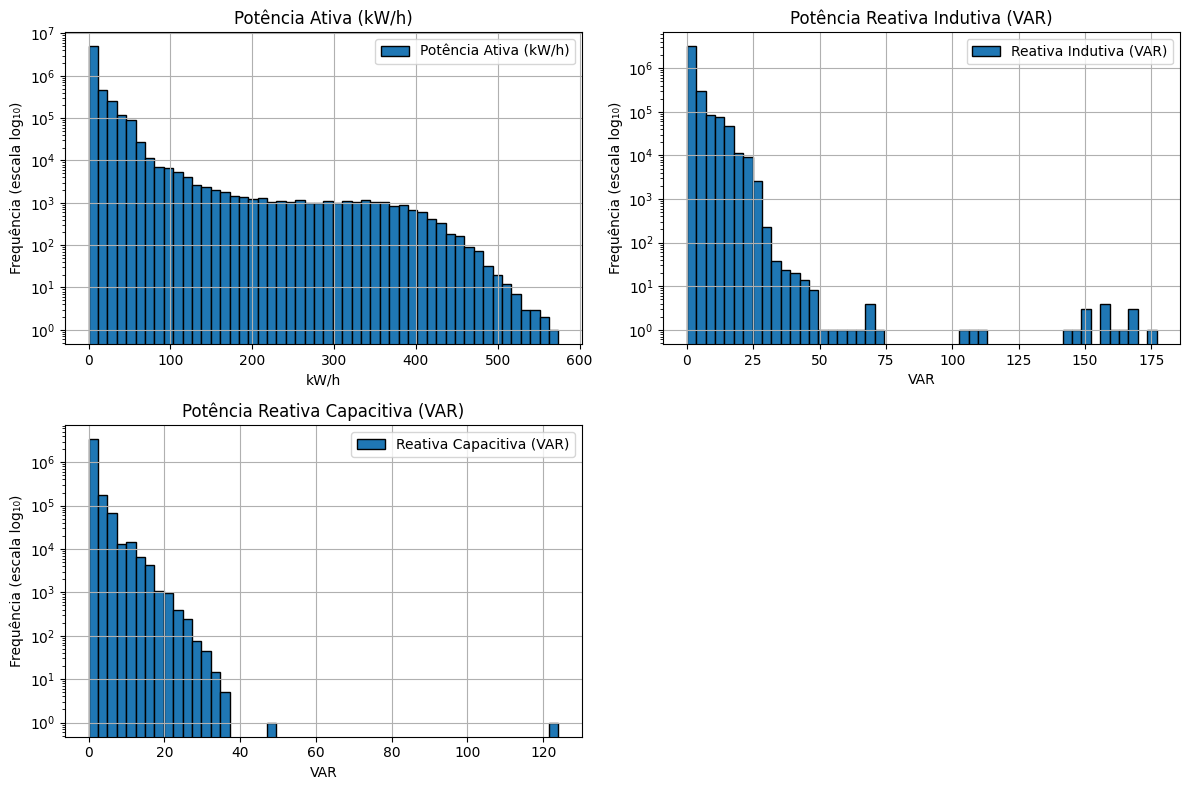

In [8]:
histo = df.select([
    "PotActiva",
    "PotReactIndut",
    "PotReactCapac"
]).to_pandas()

axes = histo.hist(
    bins=50,
    figsize=(12, 8),
    log=True,
    color="#1f77b4",
    edgecolor="black"
)

# Etiquetas e legendas
for ax in axes.flatten():
    col = ax.get_title()

    # Ajustar legendas e unidades
    if col == "PotActiva":
        ax.set_title("Potência Ativa (kW/h)")
        ax.legend(["Potência Ativa (kW/h)"])
        ax.set_xlabel("kW/h")

    elif col == "PotReactIndut":
        ax.set_title("Potência Reativa Indutiva (VAR)")
        ax.legend(["Reativa Indutiva (VAR)"])
        ax.set_xlabel("VAR")

    elif col == "PotReactCapac":
        ax.set_title("Potência Reativa Capacitiva (VAR)")
        ax.legend(["Reativa Capacitiva (VAR)"])
        ax.set_xlabel("VAR")

    # Eixo Y (frequência em escala log)
    ax.set_ylabel("Frequência (escala log₁₀)")

plt.tight_layout()
plt.show()

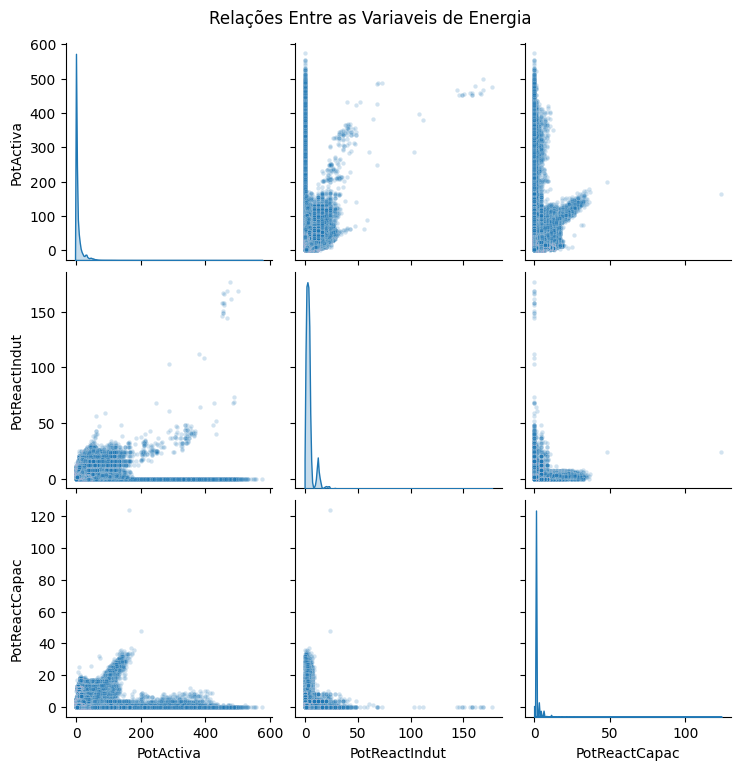

In [9]:
sns.pairplot(
    histo,
    diag_kind="kde",
    plot_kws={"alpha": 0.2, "s": 10} 
)
plt.suptitle("Relações Entre as Variaveis de Energia", y=1.02)
plt.show()

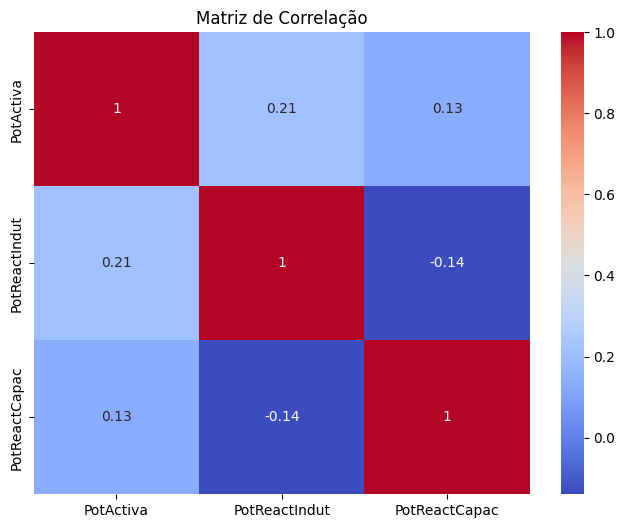

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(histo.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

A matriz de correlação mostra que as três variáveis energéticas analisadas têm uma relação fraca entre si. A potência ativa apresenta apenas uma correlação ligeiramente positiva com a potência reativa indutiva (0.21) e uma ainda mais baixa com a componente capacitiva (0.13). Isto significa que, mesmo quando a potência ativa aumenta, as componentes reativas nem sempre acompanham esse aumento de forma clara ou consistente. Também se observa uma correlação fraca e negativa entre a potência reativa indutiva e capacitiva (-0.14).
No geral, estes valores mostram que as variáveis não são redundantes e captam dimensões distintas do comportamento elétrico dos edifícios, o que as torna úteis para as fases seguintes de preparação e modelação dos dados.

## Análise Temporal
Como o dataset inclui timestamps, é útil analisar o comportamento das variáveis ao longo do tempo permitindo:
<p>-identificar padrões diários e semanais;<p>
-ajudar a perceber períodos de maior e menor atividade; <p>
-facilitar a deteção de picos, anomalias e variações sazonais;



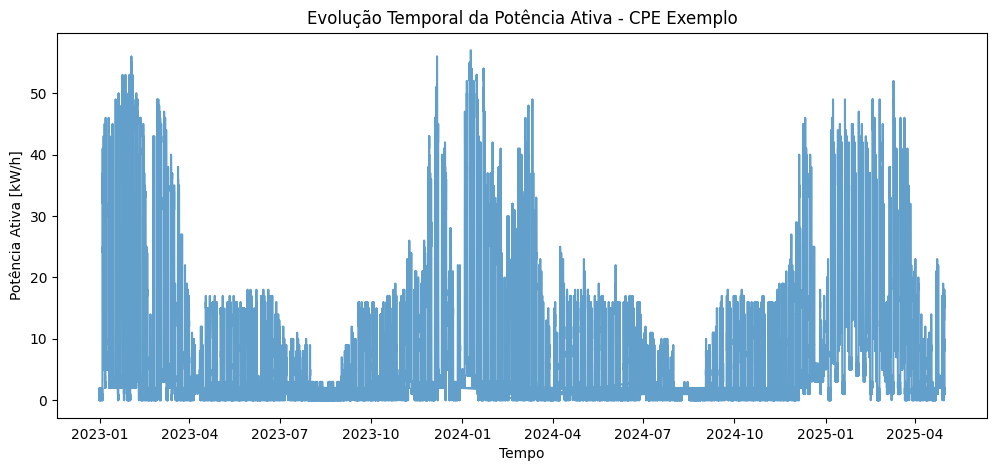

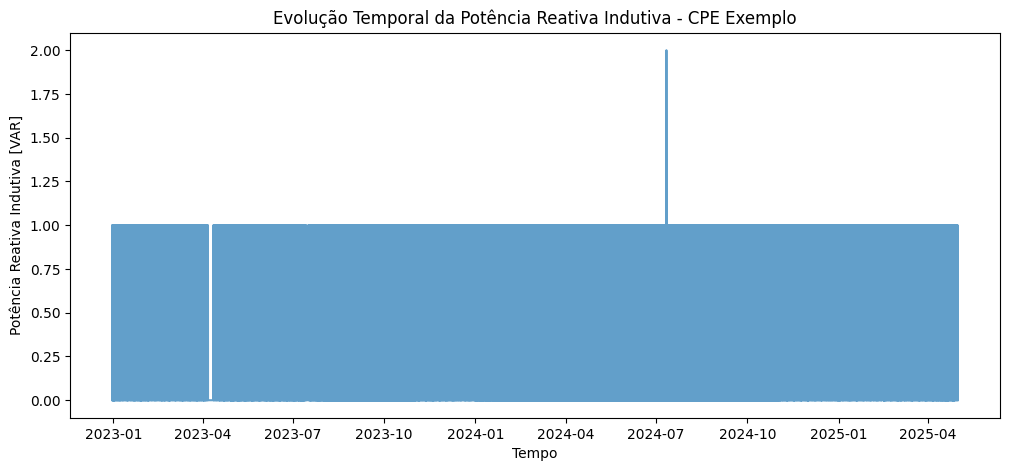

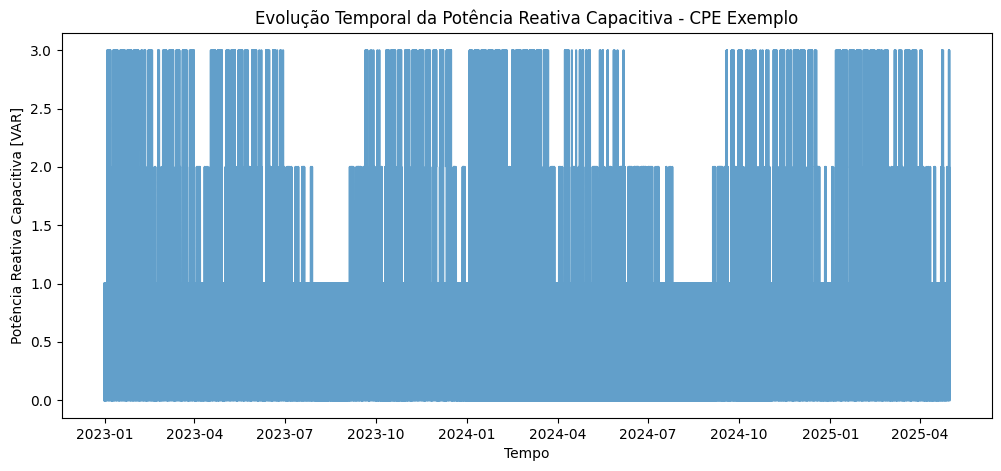

In [11]:
sample_cpe = df.filter(pl.col("CPE") == df["CPE"][1000000])  # escolher 1 edificio
pdf = sample_cpe.to_pandas()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotActiva"], alpha=0.7)
plt.title("Evolução Temporal da Potência Ativa - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa [kW/h]")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotReactIndut"], alpha=0.7)
plt.title("Evolução Temporal da Potência Reativa Indutiva - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Reativa Indutiva [VAR]")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotReactCapac"], alpha=0.7)
plt.title("Evolução Temporal da Potência Reativa Capacitiva - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Reativa Capacitiva [VAR]")
plt.show()

### Perfis Diários, semanais e mensais

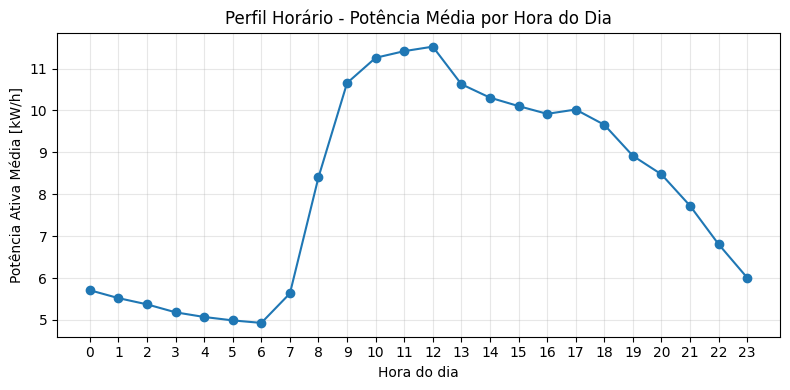

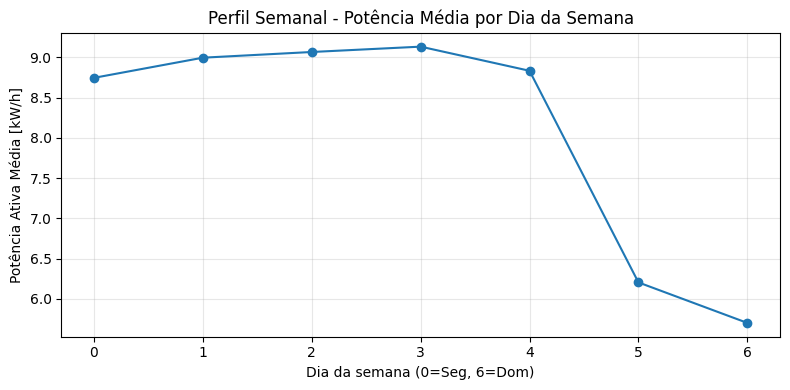

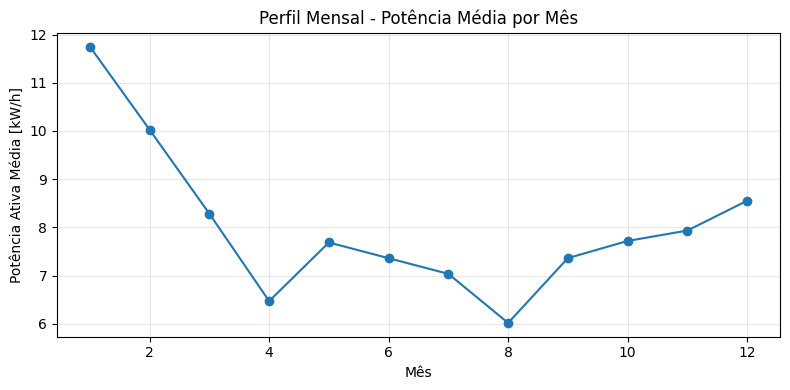

In [12]:
# Perfil Diário
pdf = df.to_pandas()
pdf["hour"] = pdf["tstamp"].dt.hour

hourly = pdf.groupby("hour")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(hourly["hour"], hourly["PotActiva"], marker="o")
plt.xlabel("Hora do dia")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Horário - Potência Média por Hora do Dia")
plt.xticks(range(0,24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Perfil Semanal
pdf["weekday"] = pdf["tstamp"].dt.weekday  

weekly = pdf.groupby("weekday")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(weekly["weekday"], weekly["PotActiva"], marker="o")
plt.xlabel("Dia da semana (0=Seg, 6=Dom)")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Semanal - Potência Média por Dia da Semana")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Perfil Mensal
pdf["month"] = pdf["tstamp"].dt.month

monthly = pdf.groupby("month")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(monthly["month"], monthly["PotActiva"], marker="o")
plt.xlabel("Mês")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Mensal - Potência Média por Mês")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



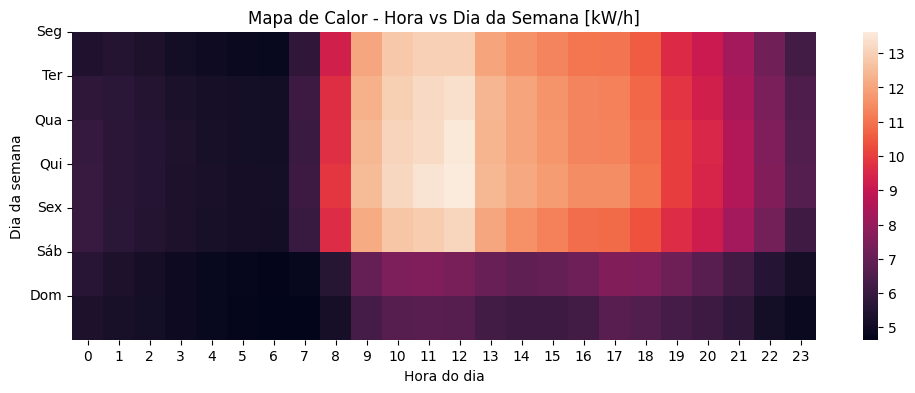

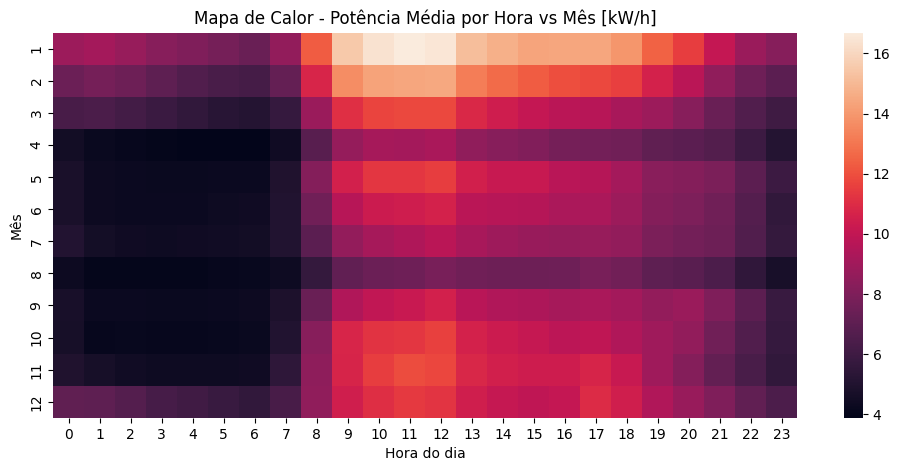

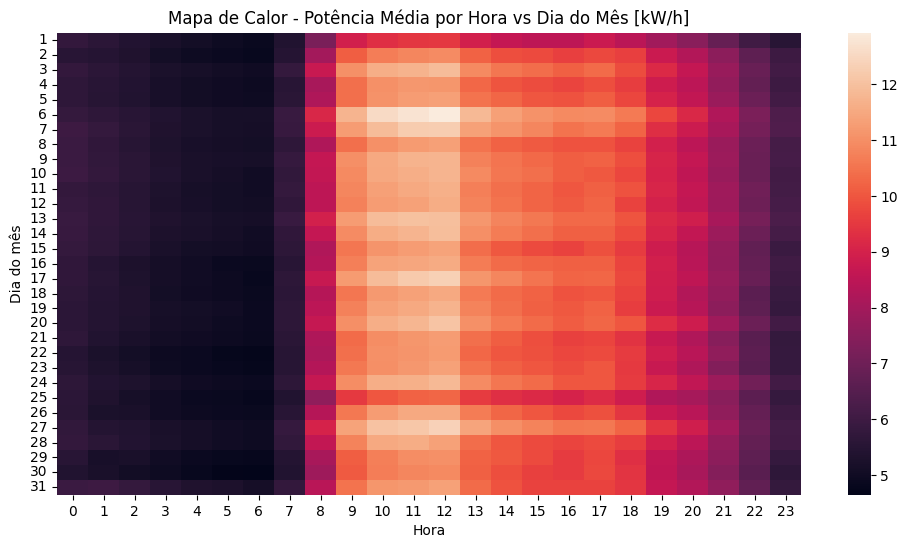

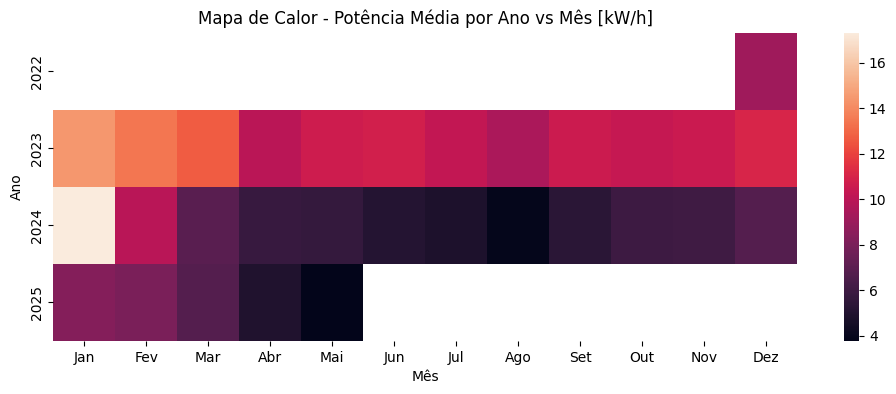

In [13]:

pdf["year"] = pdf["tstamp"].dt.year
pdf["month"] = pdf["tstamp"].dt.month
pdf["weekday"] = pdf["tstamp"].dt.weekday
pdf["hour"] = pdf["tstamp"].dt.hour
pdf["day"] = pdf["tstamp"].dt.day
pivot = pdf.pivot_table(
    values="PotActiva",
    index="weekday",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,4))
sns.heatmap(pivot, cmap="rocket")

# Títulos
plt.title("Mapa de Calor - Hora vs Dia da Semana [kW/h]")
plt.xlabel("Hora do dia")
plt.ylabel("Dia da semana")

# Substituir 0..6 pelos nomes
dias = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
plt.yticks(ticks=range(7), labels=dias, rotation=0)

pivot_month_hour = pdf.pivot_table(
    values="PotActiva",
    index="month",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,5))
sns.heatmap(pivot_month_hour, cmap="rocket")
plt.title("Mapa de Calor - Potência Média por Hora vs Mês [kW/h]")
plt.xlabel("Hora do dia")
plt.ylabel("Mês")
plt.show()


pivot_day_hour = pdf.pivot_table(
    values="PotActiva",
    index="day",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot_day_hour, cmap="rocket")
plt.title("Mapa de Calor - Potência Média por Hora vs Dia do Mês [kW/h]")
plt.xlabel("Hora")
plt.ylabel("Dia do mês")
plt.show()



pivot_year_month = pdf.pivot_table(
    values="PotActiva",
    index="year",
    columns="month",
    aggfunc="mean"
)
meses = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun",
         "Jul", "Ago", "Set", "Out", "Nov", "Dez"]

plt.figure(figsize=(12,4))
sns.heatmap(pivot_year_month, cmap="rocket", 
            xticklabels=meses)
plt.title("Mapa de Calor - Potência Média por Ano vs Mês [kW/h]")
plt.xlabel("Mês")
plt.ylabel("Ano")
plt.show()

Top 3 CPE com maior consumo total: ['PT0002000078441876HB', 'PT0002000100113293JT', 'PT0002000068856781NM']


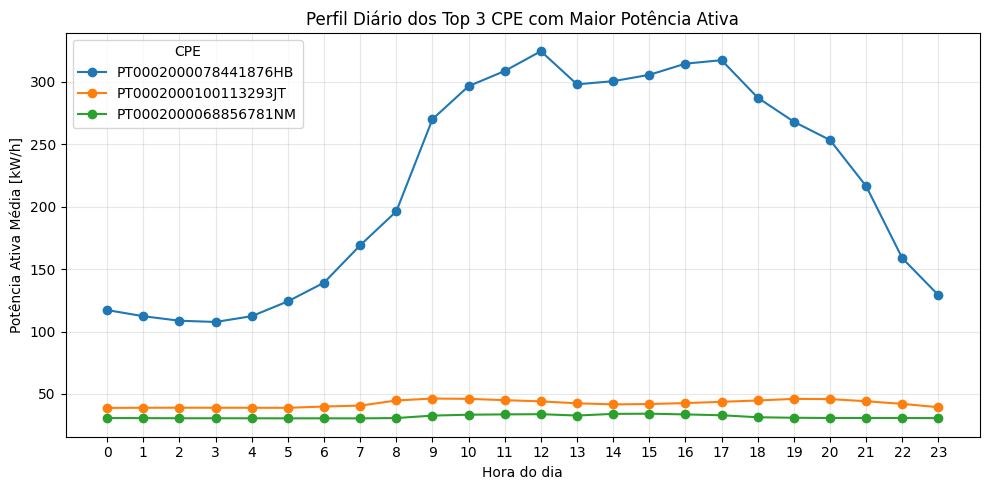

In [14]:
top3 = (
    df.group_by("CPE")
      .agg(pl.col("PotActiva").sum().alias("total"))
      .sort("total", descending=True)
      .head(3)
      .to_pandas()
)

top3_list = top3["CPE"].tolist()
print("Top 3 CPE com maior consumo total:", top3_list)

# Filtrar apenas CPE do Top 3
pdf_top = pdf[pdf["CPE"].isin(top3_list)]

perfis = (
    pdf_top.groupby(["CPE", "hour"])["PotActiva"]
           .mean()
           .reset_index()
)

# Gráfico dos perfis diários
plt.figure(figsize=(10,5))

for cpe in top3_list:
    subset = perfis[perfis["CPE"] == cpe]
    plt.plot(subset["hour"], subset["PotActiva"], marker='o', label=cpe)

plt.title("Perfil Diário dos Top 3 CPE com Maior Potência Ativa")
plt.xlabel("Hora do dia")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.xticks(range(24))
plt.grid(alpha=0.3)
plt.legend(title="CPE")
plt.tight_layout()
plt.show()

# 4. Data Preparation
Nesta fase o objetivo é transformar os dados brutos num formato adequado para análise e modelação. São aplicados procedimentos de limpeza, tratamento de valores em falta, criação de novas features temporais e filtragem de valores anómalos.

As principais tarefas realizadas foram:

- Tratamento de valores ausentes.

- Remoção de registos inválidos (potências negativas, duplicados, etc.).

- Criação de variáveis temporais (hora, dia da semana, mês, ano…).

- Verificação de outliers na potência ativa.

In [15]:
prep_df = df.clone()
prep_df.head(1)

shape: (1, 6)
┌──────────────────────┬──────────────┬────────────────┬───────────┬───────────────┬───────────────┐
│ CPE                  ┆ tstamp       ┆ DadosdeConsumo ┆ PotActiva ┆ PotReactIndut ┆ PotReactCapac │
│ ---                  ┆ ---          ┆ ---            ┆ ---       ┆ ---           ┆ ---           │
│ str                  ┆ datetime[μs] ┆ f64            ┆ f64       ┆ f64           ┆ f64           │
╞══════════════════════╪══════════════╪════════════════╪═══════════╪═══════════════╪═══════════════╡
│ PT0002000089069203YG ┆ 2022-12-31   ┆ null           ┆ 0.296     ┆ null          ┆ null          │
│                      ┆ 00:15:00     ┆                ┆           ┆               ┆               │
└──────────────────────┴──────────────┴────────────────┴───────────┴───────────────┴───────────────┘

## 4.1 Remove coluna "DadosdeConsumo"

In [16]:
prep_df = prep_df.drop("DadosdeConsumo")
prep_df.head(1)

shape: (1, 5)
┌──────────────────────┬─────────────────────┬───────────┬───────────────┬───────────────┐
│ CPE                  ┆ tstamp              ┆ PotActiva ┆ PotReactIndut ┆ PotReactCapac │
│ ---                  ┆ ---                 ┆ ---       ┆ ---           ┆ ---           │
│ str                  ┆ datetime[μs]        ┆ f64       ┆ f64           ┆ f64           │
╞══════════════════════╪═════════════════════╪═══════════╪═══════════════╪═══════════════╡
│ PT0002000089069203YG ┆ 2022-12-31 00:15:00 ┆ 0.296     ┆ null          ┆ null          │
└──────────────────────┴─────────────────────┴───────────┴───────────────┴───────────────┘

## 4.2 Remove registos duplicados

In [17]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.unique(subset=["CPE", "tstamp"], maintain_order=True)
depois = prep_df.count().get_column("CPE")[0]

print("Registos duplicados removidos:", antes - depois)

Registos duplicados removidos: 1230


## 4.3 Remove registos com potências negativas 

In [18]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.filter(pl.col("PotActiva") >= 0)
depois = prep_df.count().get_column("CPE")[0]

print("Registos com potências inválidas removidas:", antes - depois)

Registos com potências inválidas removidas: 0


## 4.4 Remove registos sem valores de potência 

In [19]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.filter(~pl.all_horizontal(pl.all().is_null()))
depois = prep_df.count().get_column("CPE")[0]

print("Registos sem potências:", antes - depois)

Registos sem potências: 0


## 4.5 Criar variáveis temporais

In [20]:
prep_pdf = prep_df.to_pandas()

# Extração temporal
prep_pdf["hour"] = prep_pdf["tstamp"].dt.hour
prep_pdf["weekday"] = prep_pdf["tstamp"].dt.weekday
prep_pdf["month"] = prep_pdf["tstamp"].dt.month
prep_pdf["year"] = prep_pdf["tstamp"].dt.year
prep_pdf["date"] = prep_pdf["tstamp"].dt.date

# Período do dia
def periodo(h):
    if 6 <= h < 12: return "morning"
    if 12 <= h < 17: return "afternoon"
    if 17 <= h < 22: return "evening"
    return "night"

prep_pdf["period"] = prep_pdf["hour"].apply(periodo)


period_features = (
    prep_pdf
    .groupby(["CPE", "period"])["PotActiva"]
    .agg(["max","mean","sum"])
    .rename(columns={
        "max":"peak_power",
        "mean":"mean_power",
        "sum":"total_power"
    })
    .unstack(fill_value=0)
)

# Flatten das colunas
period_features.columns = [
    f"{metric}_{period}"
    for metric, period in period_features.columns
]

period_features = period_features.reset_index().set_index("CPE")


inductive_period_features = (
    prep_pdf
    .groupby(["CPE", "period"])["PotReactIndut"]
    .agg(["max","mean","sum"])
    .fillna(0)
    .rename(columns={
        "max":"inductive_peak_power",
        "mean":"inductive_mean_power",
        "sum":"inductive_total_power"
    })
    .unstack(fill_value=0)
)

# Flatten das colunas
inductive_period_features.columns = [
    f"{metric}_{period}"
    for metric, period in inductive_period_features.columns
]

inductive_period_features = inductive_period_features.reset_index().set_index("CPE")


capacitive_period_features = (
    prep_pdf
    .groupby(["CPE", "period"])["PotReactCapac"]
    .agg(["max","mean","sum"])
    .fillna(0)
    .rename(columns={
        "max":"capacitive_peak_power",
        "mean":"capacitive_mean_power",
        "sum":"capacitive_total_power"
    })
    .unstack(fill_value=0)
)

# Flatten das colunas
capacitive_period_features.columns = [
    f"{metric}_{period}"
    for metric, period in capacitive_period_features.columns
]

capacitive_period_features = capacitive_period_features.reset_index().set_index("CPE")


daily = (
    prep_pdf
    .groupby(["CPE","date"])["PotActiva"]
    .agg(["max","std","mean"])
    .rename(columns={
        "max":"daily_peak",
        "std":"daily_std",
        "mean":"daily_mean",
    })
    .reset_index()
)

# time_below50
time_below50 = (
    prep_pdf.groupby(["CPE","date"])
    .apply(lambda x: (x["PotActiva"] < x["PotActiva"].mean() * 0.5).sum(),
           include_groups=False)
    .reset_index(name="time_below50")
)

# merge no daily
daily = daily.merge(time_below50, on=["CPE","date"]).set_index(["CPE","date"])

# agregação final por CPE
daily_features = (
    daily.groupby("CPE").mean()
    .rename(columns={
        "daily_peak":"avg_daily_peak",
        "daily_std":"avg_daily_std",
        "daily_mean":"avg_daily_mean",
        "time_below50":"avg_time_below50"
    })
)


weekly = (
    prep_pdf.groupby(["CPE","weekday"])["PotActiva"]
    .mean()
    .rename("weekday_mean")
)

weekday_table = weekly.unstack()

weekly_ratio = pd.DataFrame({
    "avg_weekday": weekday_table.loc[:,0:4].mean(axis=1),
    "avg_weekend": weekday_table.loc[:,5:6].mean(axis=1),
})

weekly_ratio["weekend_weekday_ratio"] = (
    weekly_ratio["avg_weekend"] / (weekly_ratio["avg_weekday"])
)

weekly_ratio["weekend_weekday_ratio"].fillna(0, inplace=True)

weekly_max = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .max()
    .rename("weekly_max")
)


prep_pdf = prep_pdf.sort_values(["CPE","tstamp"])

lags = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .apply(lambda x: pd.DataFrame({
        "lag_1day": x.shift(96),
        "lag_1week": x.shift(96*7),
        "roll_1day": x.rolling(96).mean(),
        "roll_1week": x.rolling(96*7).mean(),
    }))
)


period_totals = (
    prep_pdf.groupby(["CPE", "period"])["PotActiva"]
    .sum()
    .unstack(fill_value=0)
)

period_totals["night_day_ratio"] = (
    period_totals["night"] /
    (period_totals["morning"] + period_totals["afternoon"] + 1e-6)
)

night_day_ratio = period_totals["night_day_ratio"]


def calc_entropy(series):
    p = series.values
    p = p[p > 0]
    if len(p) == 0:
        return 0.0
    p = p / p.sum()
    return entropy(p)

entropy_feature = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .apply(calc_entropy)
    .rename("entropy")
)


prep_pdf["has_Q"] = np.where(
    prep_pdf["PotReactIndut"].notna() | prep_pdf["PotReactCapac"].notna(),
    1.0,
    -1.0
)

mask_Q = prep_pdf["PotReactIndut"].notna() | prep_pdf["PotReactCapac"].notna()

prep_pdf.loc[mask_Q, "Q_total"] = (
    prep_pdf["PotReactIndut"].fillna(0)
    - prep_pdf["PotReactCapac"].fillna(0)
)

mask_PQ = mask_Q & prep_pdf["PotActiva"].notna()
P = prep_pdf.loc[mask_PQ, "PotActiva"]
Q = prep_pdf.loc[mask_PQ, "Q_total"]

prep_pdf.loc[mask_PQ, "PF"] = P / np.sqrt(P**2 + Q**2)

react_features = (
    prep_pdf.groupby("CPE")
    .agg({
        "has_Q": "mean",
        "Q_total": ["mean", "std"],
        "PF": ["mean", "std"],
    })
)

react_features.columns = [
    "has_Q_mean",
    "Q_mean",
    "Q_std",
    "pf_mean",
    "pf_std",
]

react_features = react_features.fillna({
    "has_Q_mean": -1.0,
    "Q_mean": 0.0,
    "Q_std": 0.0,
    "pf_mean": 1.0,
    "pf_std": 0.0,
})


features_final = (
      daily_features
    .join(period_features, how="left")
    .join(inductive_period_features, how="left")
    .join(capacitive_period_features, how="left")
    .join(weekly_ratio, how="left")
    .join(weekly_max, how="left")
    .join(night_day_ratio, how="left")
    .join(entropy_feature, how="left")
    .join(react_features, how="left")
)

features_final.head()

avg_daily_peak  avg_daily_std  avg_daily_mean  \
CPE                                                                   
PT0002000032936306KX        5.334452       2.546508        2.451701   
PT0002000032942455NH        0.257027       0.054953        0.090997   
PT0002000032959511HP        0.000000       0.000000        0.000000   
PT0002000032966446CC        0.322175       0.066023        0.099622   
PT0002000032968749YT       11.542965       2.627443        3.636439   

                      avg_time_below50  peak_power_afternoon  \
CPE                                                            
PT0002000032936306KX         47.155779                 5.320   
PT0002000032942455NH         20.579104                 1.724   
PT0002000032959511HP          0.000000                 0.000   
PT0002000032966446CC         22.942623                 2.100   
PT0002000032968749YT         23.951754                26.524   

                      peak_power_evening  peak_power_morning  \
CPE                                                            
PT0002000032936306KX              22.324              28.584   
PT0002000032942455NH               2.860               1.656   
PT0002000032959511HP               0.000               0.000   
PT0002000032966446CC               2.132               2.244   
PT0002000032968749YT              13.508              31.496   

                      peak_power_night  mean_power_afternoon  \
CPE                                                            
PT0002000032936306KX            30.756              0.004103   
PT0002000032942455NH             2.312              0.097075   
PT0002000032959511HP             0.000              0.000000   
PT0002000032966446CC             2.056              0.098169   
PT0002000032968749YT            14.264              5.214901   

                      mean_power_evening  ...  avg_weekend  \
CPE                                       ...                
PT0002000032936306KX            2.229179  ...     2.410955   
PT0002000032942455NH            0.102223  ...     0.065112   
PT0002000032959511HP            0.000000  ...     0.000000   
PT0002000032966446CC            0.120989  ...     0.090993   
PT0002000032968749YT            2.232900  ...     1.811569   

                      weekend_weekday_ratio  weekly_max  night_day_ratio  \
CPE                                                                        
PT0002000032936306KX               0.985326      30.756         7.005935   
PT0002000032942455NH               0.643920       2.860         0.749189   
PT0002000032959511HP               0.000000       0.000         0.000000   
PT0002000032966446CC               0.881472       2.244         0.799314   
PT0002000032968749YT               0.414477      31.496         0.284843   

                        entropy  has_Q_mean  Q_mean  Q_std  pf_mean  pf_std  
CPE                                                                          
PT0002000032936306KX   9.745128        -1.0     0.0    0.0      1.0     0.0  
PT0002000032942455NH   9.732032        -1.0     0.0    0.0      1.0     0.0  
PT0002000032959511HP   0.000000        -1.0     0.0    0.0      1.0     0.0  
PT0002000032966446CC  10.060483        -1.0     0.0    0.0      1.0     0.0  
PT0002000032968749YT  10.231756        -1.0     0.0    0.0      1.0     0.0  

[5 rows x 51 columns]

# Dicionário de Features

## 1. Métricas Diárias
- **avg_daily_peak** — Pico diário médio da Potência Ativa.
- **avg_daily_mean** — Consumo médio diário típico.
- **avg_daily_std** — Variabilidade média diária.
- **avg_time_below50** — Nº médio de registos/dia abaixo de 50% do consumo diário.


## 2. Métricas por Período do Dia
Períodos:
**morning (06–12)** · **afternoon (12–17)** · **evening (17–22)** · **night (22–06)**

Para cada período existem 3 features:

- **mean_power_<period>** — Consumo médio.
- **peak_power_<period>** — Pico máximo.
- **total_power_<period>** — Consumo acumulado.

*Ex.: `mean_power_afternoon`, `peak_power_evening`, `total_power_night`*


## 3. Padrões Semanais
- **avg_weekday** — Consumo médio de 2ª a 6ª.
- **avg_weekend** — Consumo médio ao fim de semana.
- **weekend_weekday_ratio** — Relação fim de semana / dias úteis.
- **weekly_max** — Máximo absoluto de Potência Ativa registado para cada CPE.


## 4. Lag & Rolling (Séries Temporais)
- **lag_1day** — Valor de Potência Ativa de 1 dia antes (96 amostras).
- **lag_1week** — Valor de 1 semana antes (96×7 amostras).
- **roll_1day** — Média móvel de 1 dia (suaviza ruído diário).
- **roll_1week** — Média móvel de 1 semana (suaviza padrões semanais).


## 6. Night–Day Ratio
- **night_day_ratio** — Mede o quão “noturno” é o padrão de consumo.


## 7. Entropia de Consumo
- **entropy** — Mede a dispersão do consumo ao longo do tempo.

*Ex.: `Valores altos → padrão irregular`, `Valores baixos → padrão consistente`*


## 8. Potência Reativa e Fator de Potência
- **frac_Q_ind** — Percentagem de medições com Potência Reativa Indutiva disponível.
- **frac_Q_cap** — Percentagem de medições com Potência Reativa Capacitiva disponível.
- **Q_mean** — Média da Potência Reativa (Indutiva – Capacitiva).
- **Q_std** — Variabilidade da Potência Reativa.
- **pf_mean** — Fator de Potência médio.
- **pf_std** — Desvio padrão do Fator de Potência.

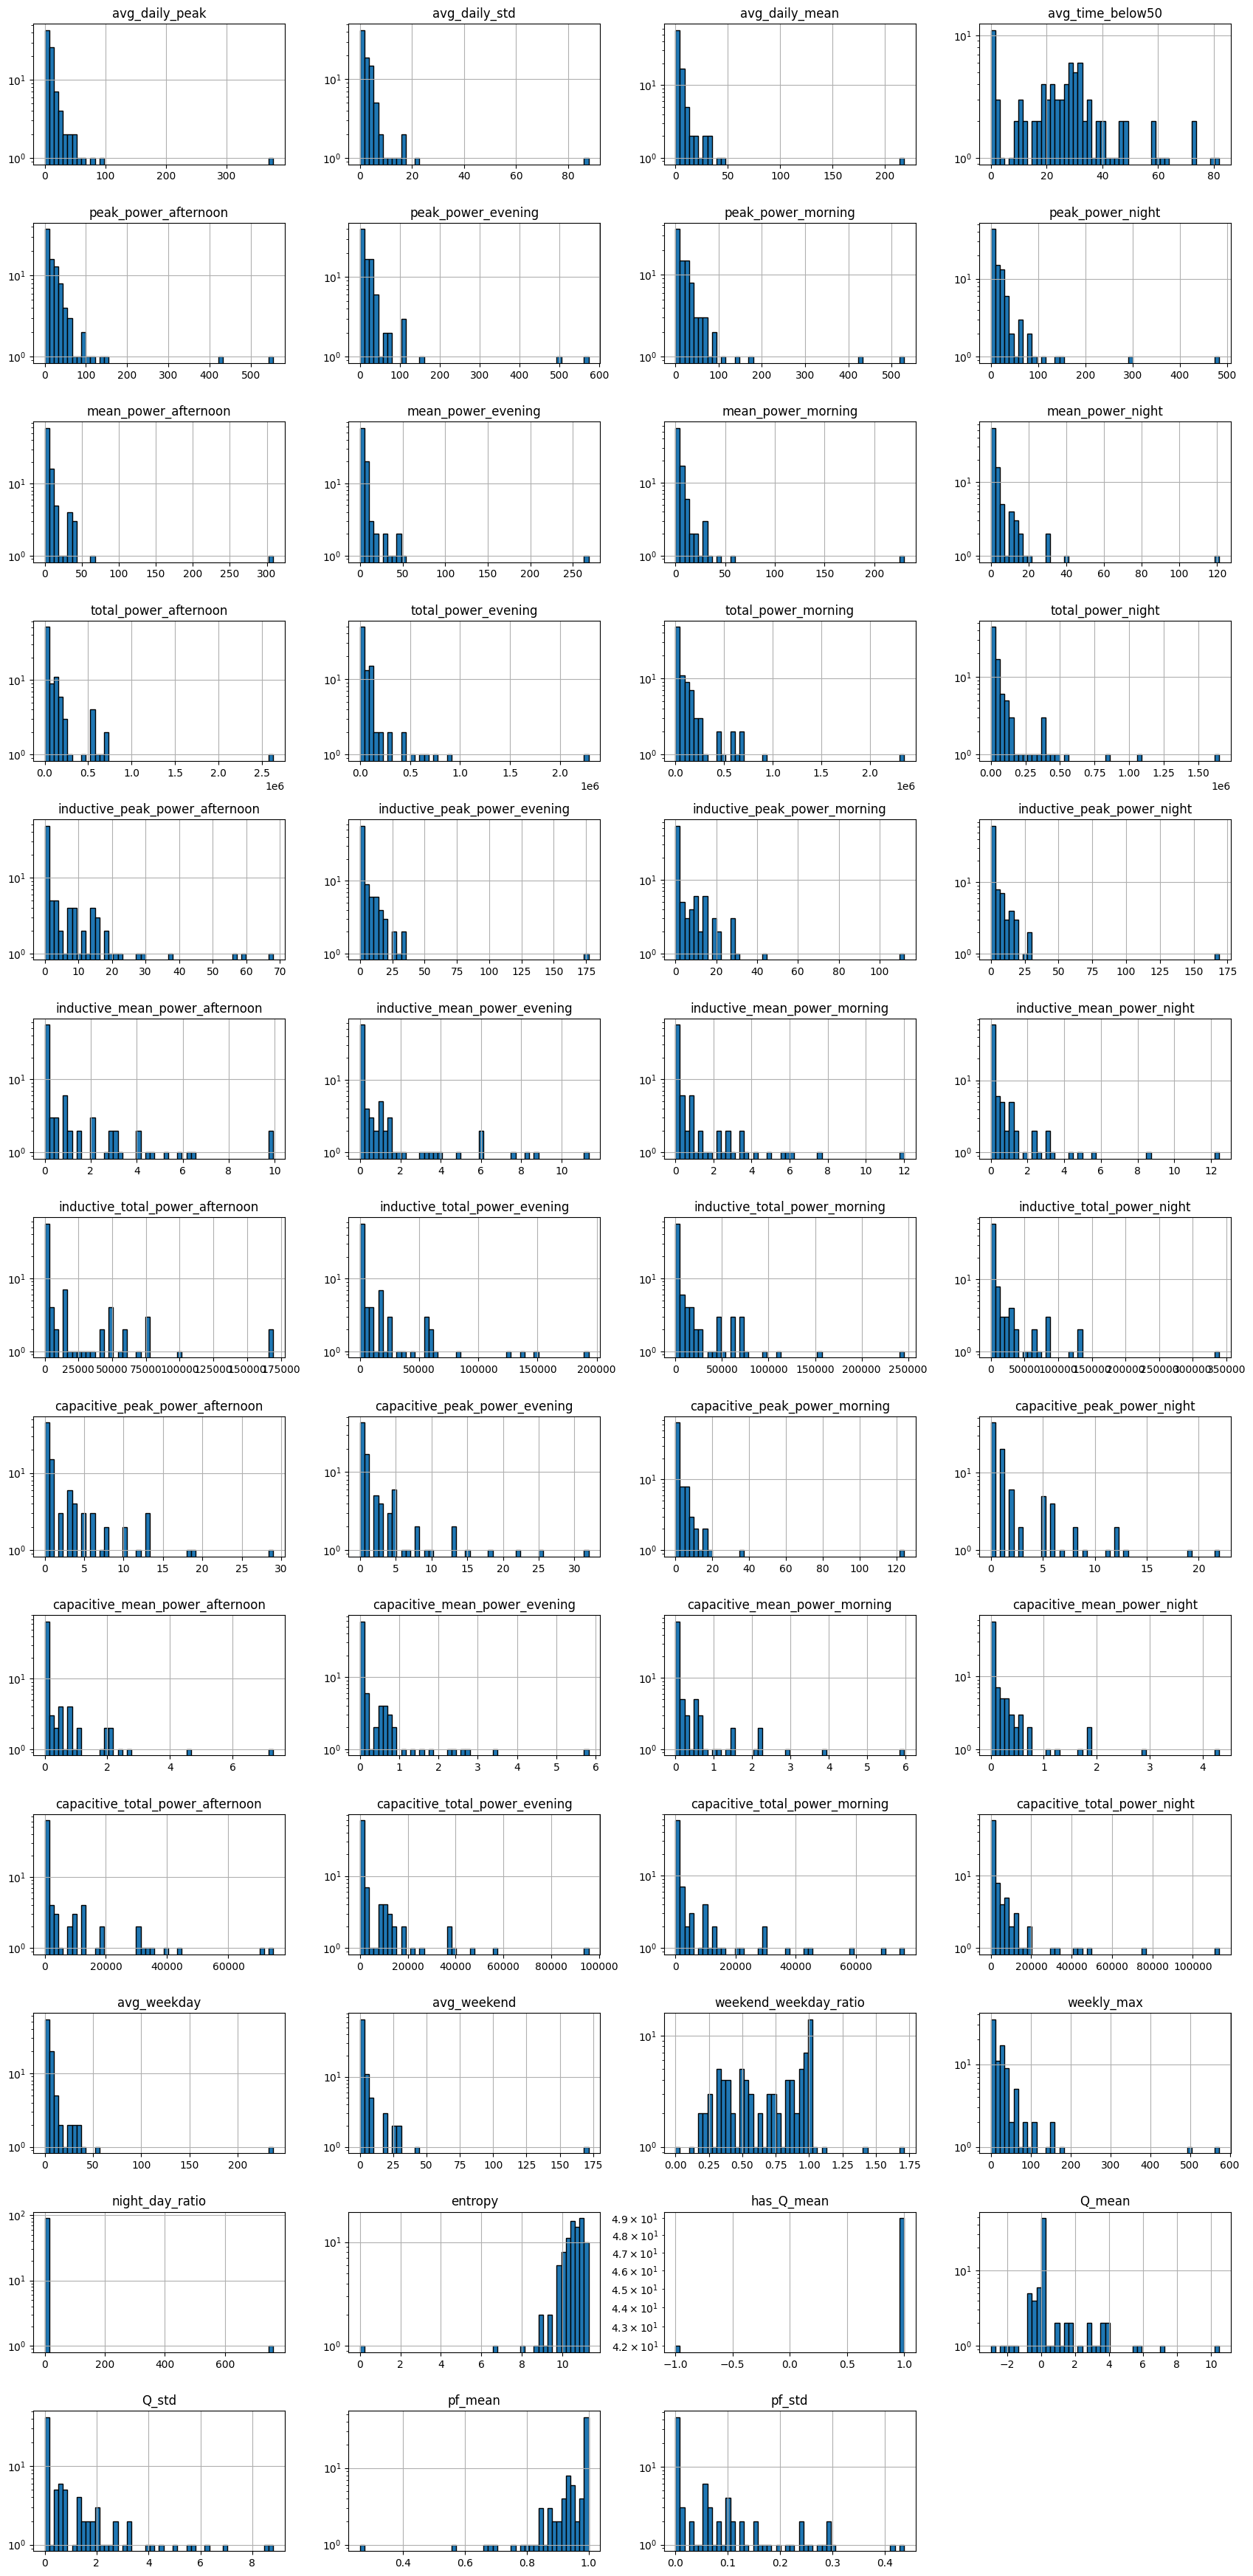

In [21]:
feat = features_final.copy()
feat = feat.reset_index()

feat.select_dtypes(include=["float","int"]).hist(
    bins=50,
    figsize=(17,35),
    log=True,
    color="#1f77b4",
    edgecolor="black",
    layout=(13,4)
)

plt.tight_layout()
plt.show()

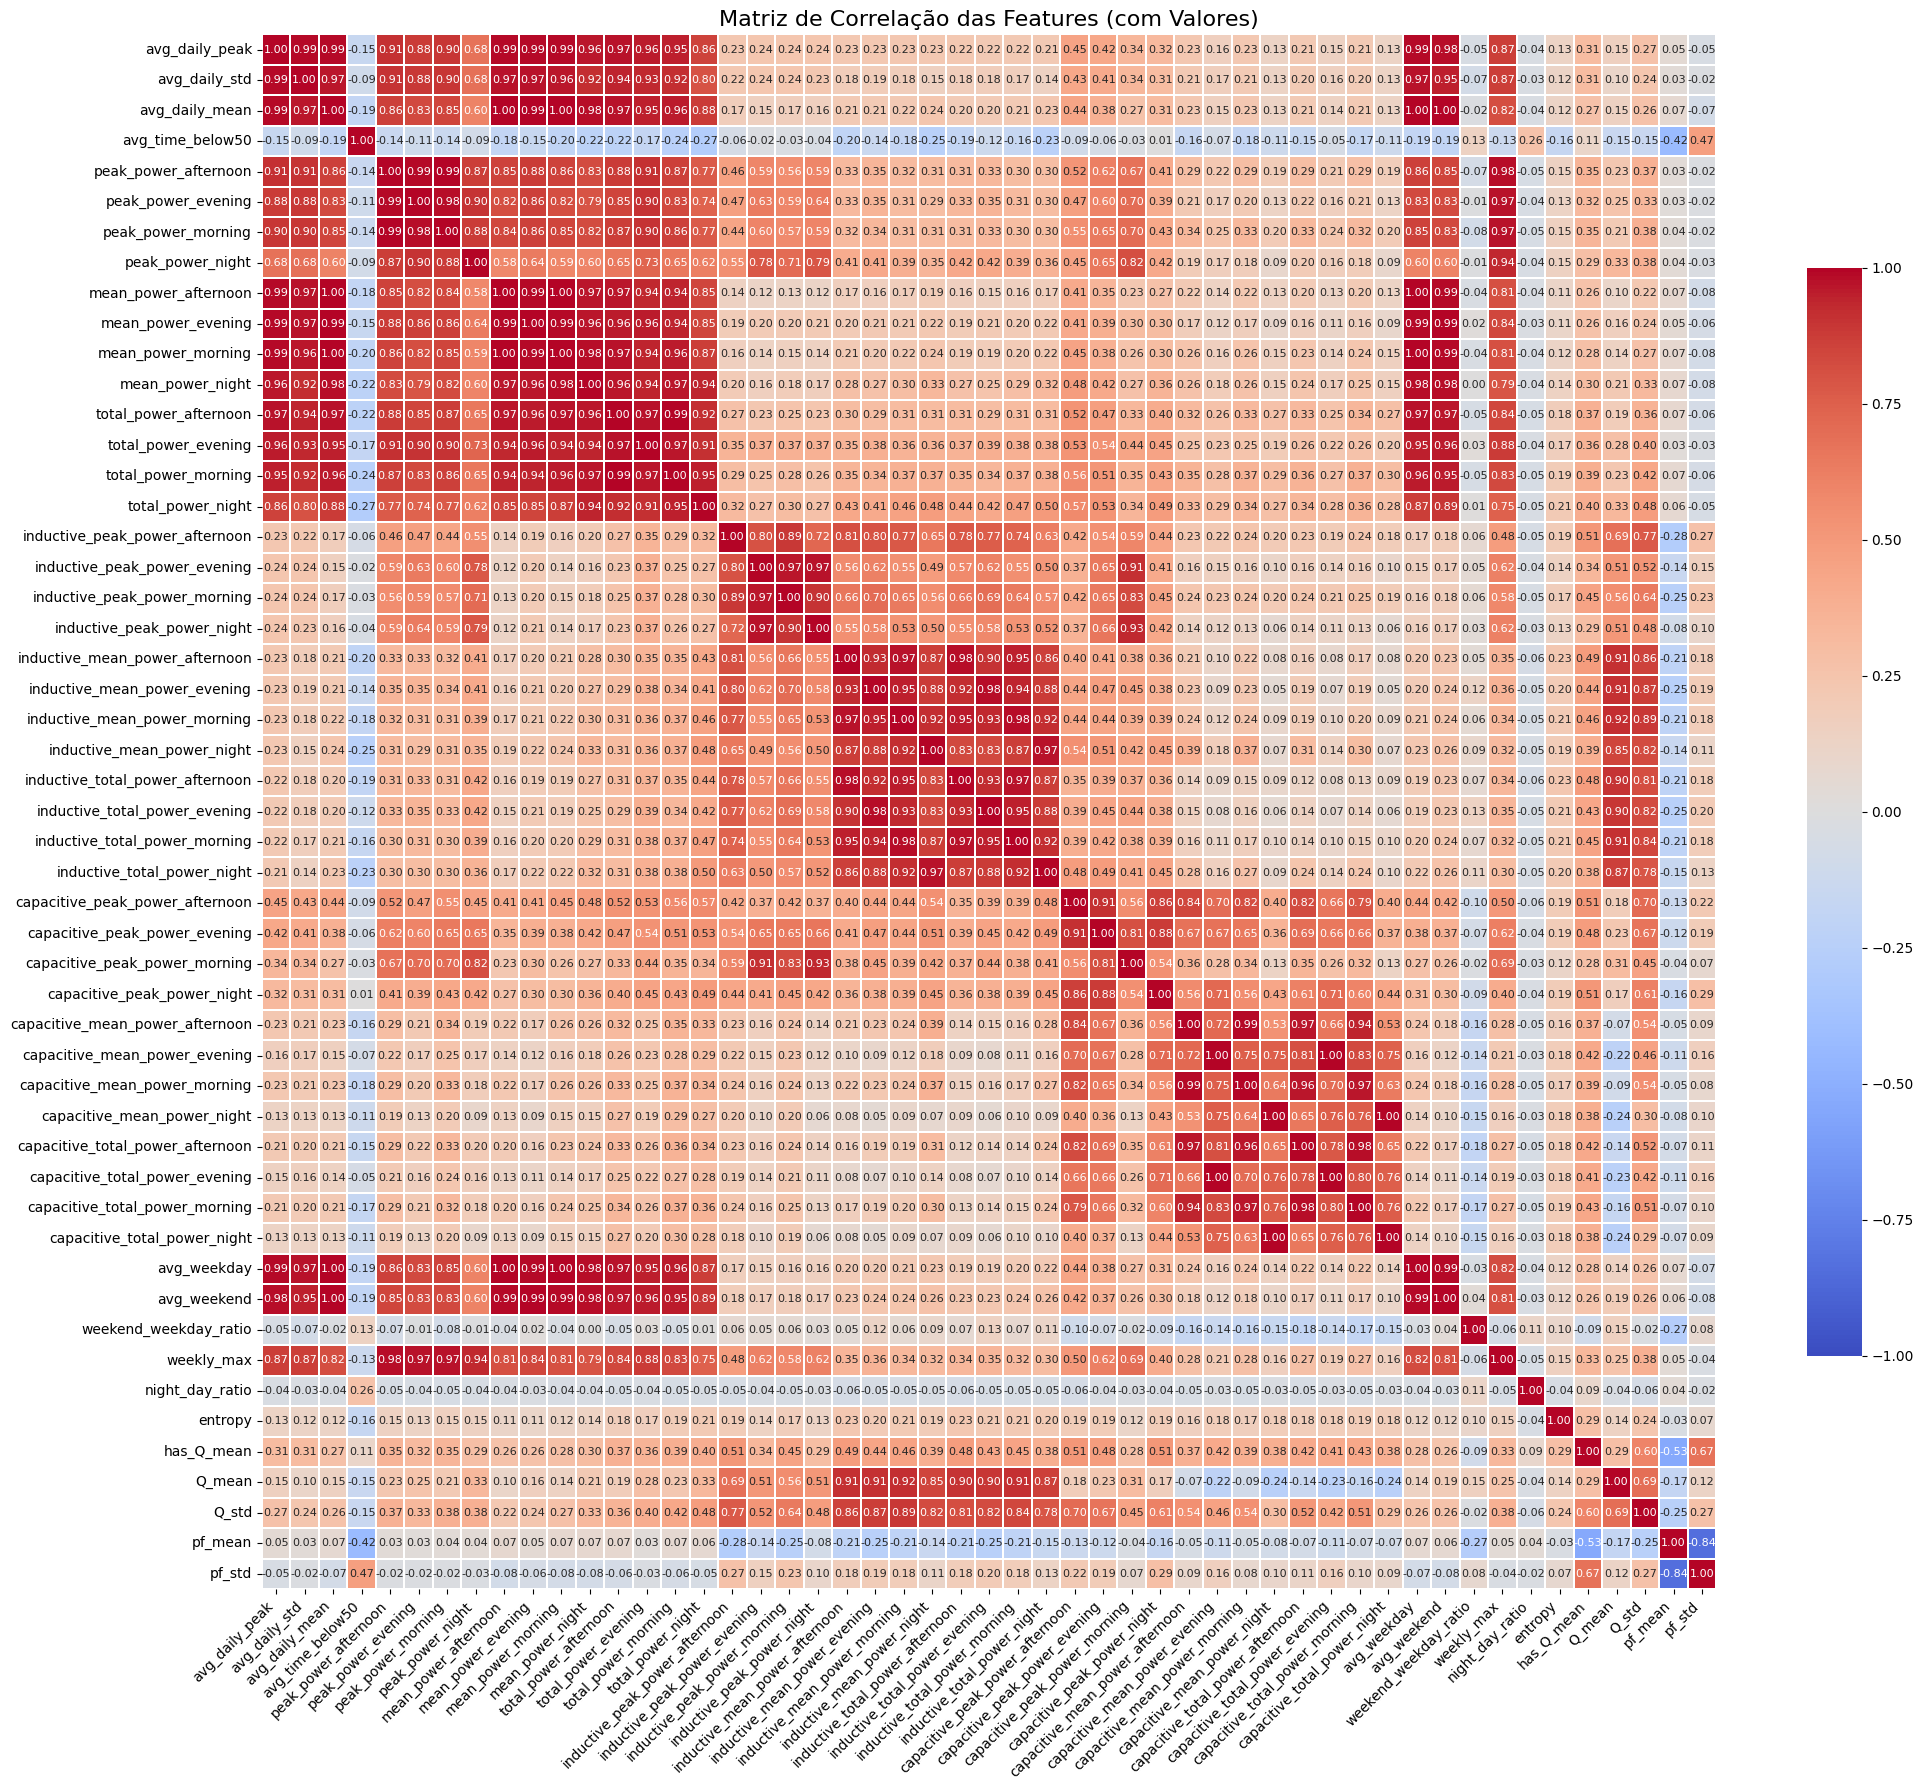

In [22]:
feat_num = feat.select_dtypes(include=["float", "int"])

plt.figure(figsize=(21,18))

sns.heatmap(
    feat_num.corr(),
    cmap="coolwarm",
    annot=True,           
    fmt=".2f",             
    annot_kws={"size": 8}, 
    linewidths=0.3,
    cbar_kws={"shrink": 0.7},
    vmin=-1.0,
    vmax=1.0
)

plt.title("Matriz de Correlação das Features (com Valores)", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
corr = feat_num.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), 1).astype(bool))

redundantes = [col for col in upper.columns if any(upper[col] > 0.95)]
redundantes

['avg_daily_std',
 'avg_daily_mean',
 'peak_power_evening',
 'peak_power_morning',
 'mean_power_afternoon',
 'mean_power_evening',
 'mean_power_morning',
 'mean_power_night',
 'total_power_afternoon',
 'total_power_evening',
 'total_power_morning',
 'total_power_night',
 'inductive_peak_power_morning',
 'inductive_peak_power_night',
 'inductive_mean_power_morning',
 'inductive_total_power_afternoon',
 'inductive_total_power_evening',
 'inductive_total_power_morning',
 'inductive_total_power_night',
 'capacitive_mean_power_morning',
 'capacitive_total_power_afternoon',
 'capacitive_total_power_evening',
 'capacitive_total_power_morning',
 'capacitive_total_power_night',
 'avg_weekday',
 'avg_weekend',
 'weekly_max']

In [24]:
features_raw = features_final.copy()
feat_num = features_raw.select_dtypes(include=["float", "int"])
corr = feat_num.corr().abs()

upper = corr.where(np.triu(np.ones(corr.shape), 1).astype(bool))

to_drop = [
    column 
    for column in upper.columns 
    if any(upper[column] > 0.95)
]

# Manter apenas features que não estão na lista to_drop
features_clean = features_raw.drop(columns=to_drop)

print("Removidas:", to_drop)
print("Total antes:", features_raw.shape[1])
print("Total depois:", features_clean.shape[1])

Removidas: ['avg_daily_std', 'avg_daily_mean', 'peak_power_evening', 'peak_power_morning', 'mean_power_afternoon', 'mean_power_evening', 'mean_power_morning', 'mean_power_night', 'total_power_afternoon', 'total_power_evening', 'total_power_morning', 'total_power_night', 'inductive_peak_power_morning', 'inductive_peak_power_night', 'inductive_mean_power_morning', 'inductive_total_power_afternoon', 'inductive_total_power_evening', 'inductive_total_power_morning', 'inductive_total_power_night', 'capacitive_mean_power_morning', 'capacitive_total_power_afternoon', 'capacitive_total_power_evening', 'capacitive_total_power_morning', 'capacitive_total_power_night', 'avg_weekday', 'avg_weekend', 'weekly_max']
Total antes: 51
Total depois: 24


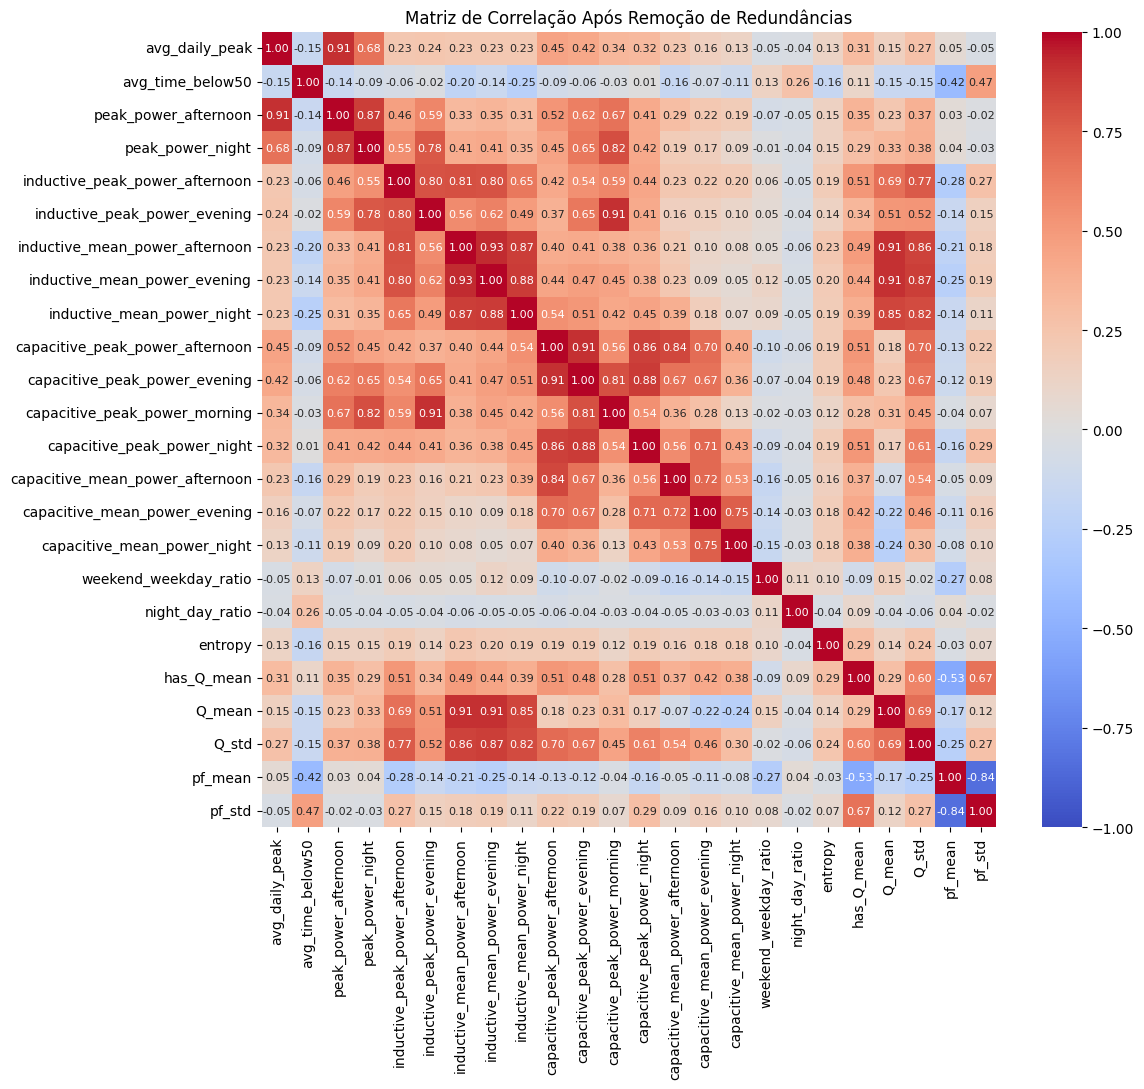

In [25]:
feat_num_clean = features_clean.select_dtypes(include=["float", "int"])

plt.figure(figsize=(12,11))
sns.heatmap(
    feat_num_clean.corr(),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size":8},
    vmin=-1.0,
    vmax=1.0
)
plt.title("Matriz de Correlação Após Remoção de Redundâncias")
plt.tight_layout()
plt.show()

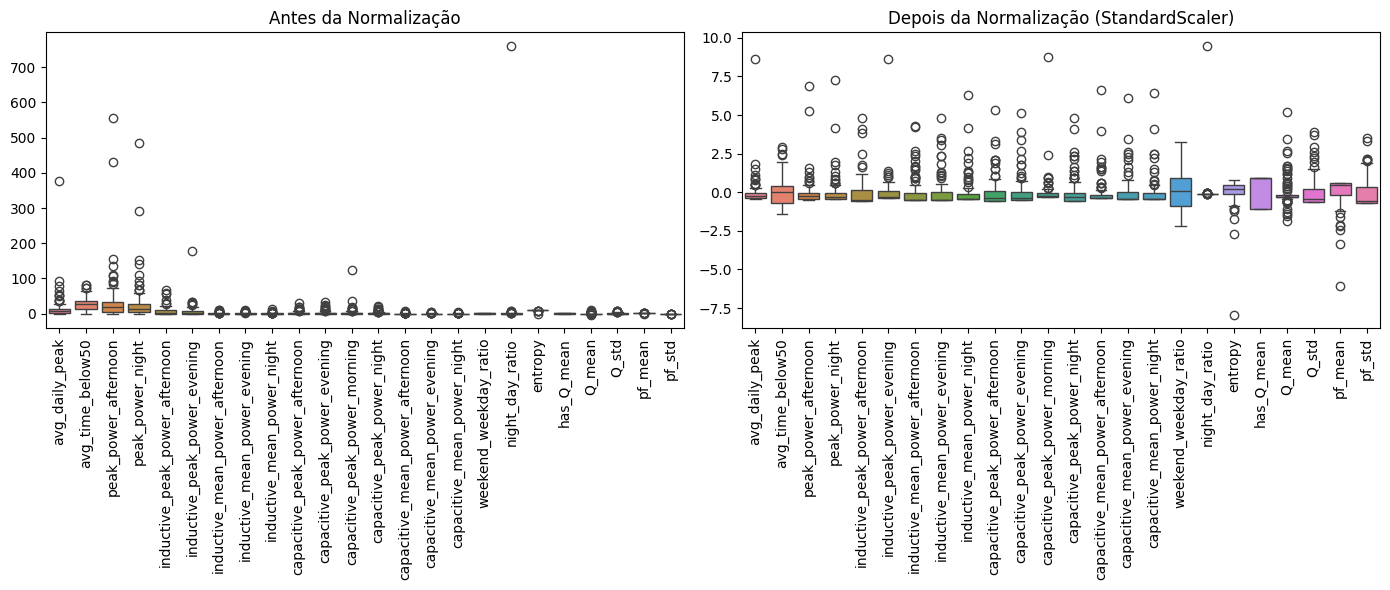

In [26]:
# Selecionar apenas features numéricas
feat = feat_num_clean.copy()
feat_num = feat.select_dtypes(include=["float", "int"])

# Remover linhas com NaN (necessário para o PCA)
feat_pca = feat_num.dropna()

# Normalização correta
scaler = StandardScaler()
feat_scaled = pd.DataFrame(
    scaler.fit_transform(feat_pca),
    index=feat_pca.index,
    columns=feat_pca.columns
)

# BOX-PLOT ANTES E DEPOIS

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.boxplot(data=feat_pca)
plt.title("Antes da Normalização")
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.boxplot(data=feat_scaled)
plt.title("Depois da Normalização (StandardScaler)")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

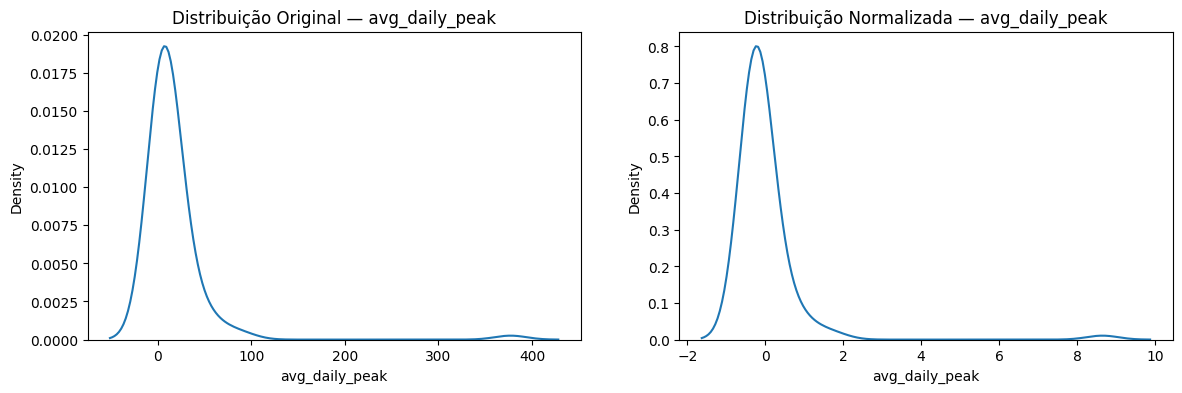

In [27]:
# distribuições antes e depois da normalização do avg_daily_peak

fig, ax = plt.subplots(1, 2, figsize=(14,4))

sns.kdeplot(feat_pca["avg_daily_peak"], ax=ax[0])
sns.kdeplot(feat_scaled["avg_daily_peak"], ax=ax[1])

ax[0].set_title("Distribuição Original — avg_daily_peak")
ax[1].set_title("Distribuição Normalizada — avg_daily_peak")

plt.show()

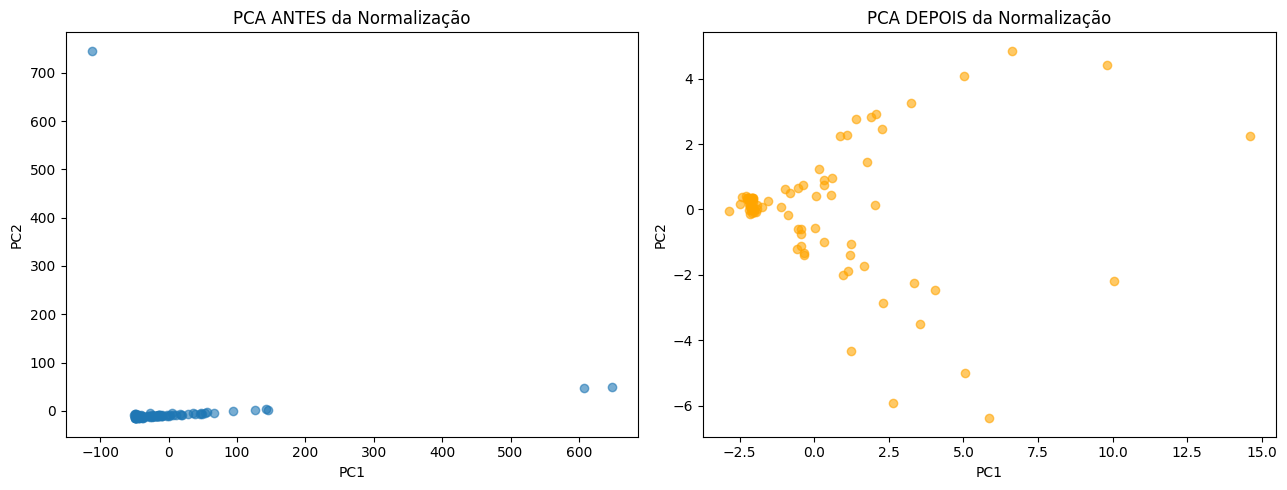

In [28]:
# PCA ANTES E DEPOIS 

pca1 = PCA(n_components=2)
pca_before = pca1.fit_transform(feat_pca)

pca2 = PCA(n_components=2)
pca_after  = pca2.fit_transform(feat_scaled)

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.scatter(pca_before[:,0], pca_before[:,1], alpha=0.6)
plt.title("PCA ANTES da Normalização")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.scatter(pca_after[:,0], pca_after[:,1], alpha=0.6, color="orange")
plt.title("PCA DEPOIS da Normalização")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.tight_layout()
plt.show()

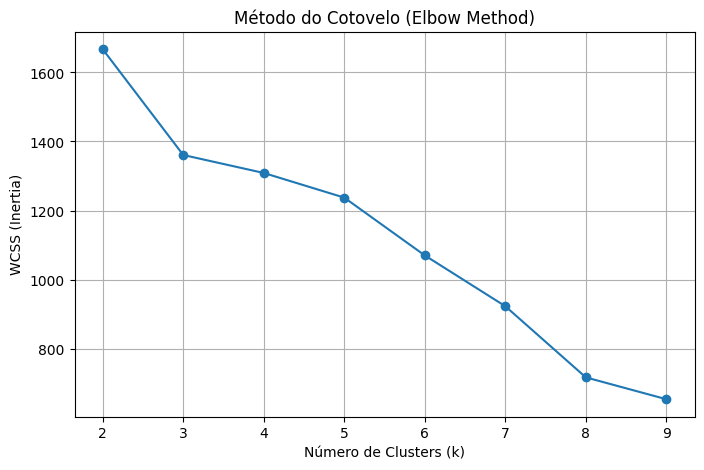

In [29]:
wcss = []  # Within-cluster sum of squares

K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(feat_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, wcss, marker='o')
plt.xlabel("Número de Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Método do Cotovelo (Elbow Method)")
plt.grid(True)
plt.show()


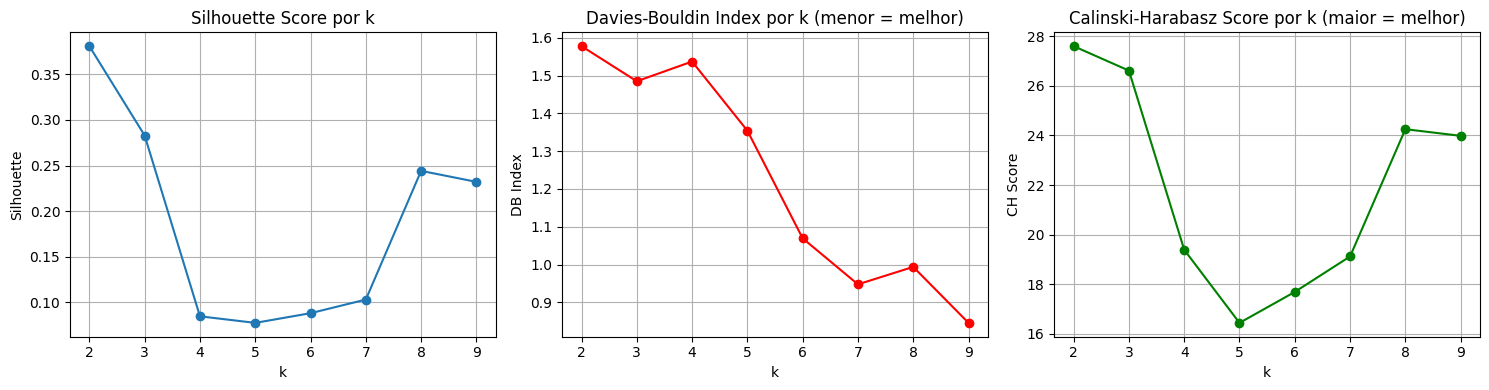

In [30]:
sil_scores = {}
dbi_scores = {}
chi_scores = {}

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(feat_scaled)

    # Silhouette
    sil_scores[k] = silhouette_score(feat_scaled, labels)

    # Davies-Bouldin (menor = melhor)
    dbi_scores[k] = davies_bouldin_score(feat_scaled, labels)

    # Calinski-Harabasz (maior = melhor)
    chi_scores[k] = calinski_harabasz_score(feat_scaled, labels)



plt.figure(figsize=(15,4))

# Silhouette
plt.subplot(1,3,1)
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Silhouette Score por k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)

# Davies–Bouldin
plt.subplot(1,3,2)
plt.plot(list(dbi_scores.keys()), list(dbi_scores.values()), marker='o', color='red')
plt.title("Davies-Bouldin Index por k (menor = melhor)")
plt.xlabel("k")
plt.ylabel("DB Index")
plt.grid(True)

# Calinski-Harabasz
plt.subplot(1,3,3)
plt.plot(list(chi_scores.keys()), list(chi_scores.values()), marker='o', color='green')
plt.title("Calinski-Harabasz Score por k (maior = melhor)")
plt.xlabel("k")
plt.ylabel("CH Score")
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
w_sil = 0.8
w_db = 0.2
w_ch = 0.0

db_inverted = {k: 1/v for k, v in dbi_scores.items()}

weighted_score = {}
for k in sil_scores.keys():
    score = (w_sil * sil_scores[k] + w_db * db_inverted[k] + w_ch * chi_scores[k])
    weighted_score[k] = score

# Find best k
best_k = max(weighted_score, key=weighted_score.get)

# Mostrar valores numéricos
print("Silhouette:")
print(sil_scores)
print("Davies-Bouldin:")
print(dbi_scores)
print("Calinski-Harabasz:")
print(chi_scores)
print("Média ponderada por k:")
print(weighted_score)
print("Melhor k:", best_k)

Silhouette:
{2: 0.3809393937795413, 3: 0.28289163832592906, 4: 0.08459084717874833, 5: 0.07737209103492015, 6: 0.08800780655334835, 7: 0.10294273324827338, 8: 0.24414442021450902, 9: 0.23206910546610934}
Davies-Bouldin:
{2: 1.5779532934173655, 3: 1.485145927957064, 4: 1.537263338570899, 5: 1.3542667453333963, 6: 1.069430186988549, 7: 0.9475935580271161, 8: 0.9937842694304582, 9: 0.8456071652587105}
Calinski-Harabasz:
{2: 27.595963674802654, 3: 26.610588009691618, 4: 19.38989587766895, 5: 16.443251336578022, 6: 17.69062665883015, 7: 19.12096787483374, 8: 24.2499471726526, 9: 23.98189809887842}
Média ponderada por k:
{2: 0.43149797883490404, 3: 0.36098021189590734, 4: 0.19777400455010768, 5: 0.209579066238186, 6: 0.25742172548004505, 7: 0.2934151402171709, 8: 0.396566457676554, 9: 0.422171728671004}
Melhor k: 2


In [32]:
#best_k = 3

kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(feat_scaled)

feat_clust = feat_scaled.copy()
feat_clust.loc[:, "cluster"] = cluster_labels

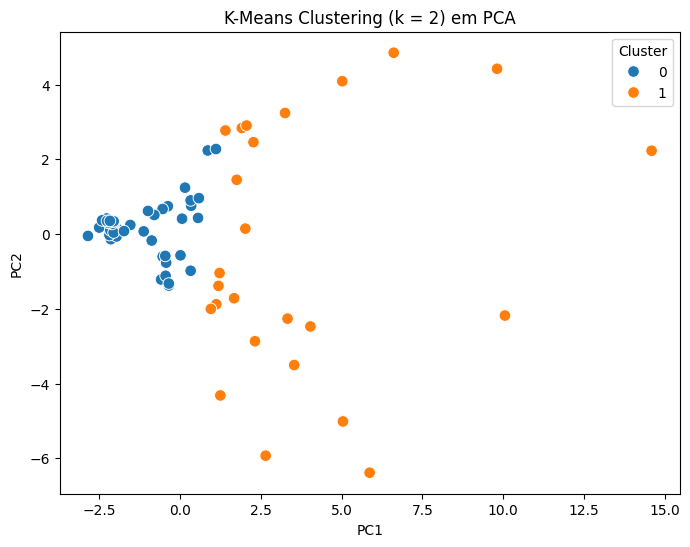

In [33]:
pca = PCA(n_components=2)
coords = pca.fit_transform(feat_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords[:,0], y=coords[:,1],
    hue=cluster_labels,
    palette='tab10',
    s=70
)

plt.title(f"K-Means Clustering (k = {best_k}) em PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

In [34]:
pca = PCA(n_components=3)
coords = pca.fit_transform(feat_scaled)

coords = coords.T

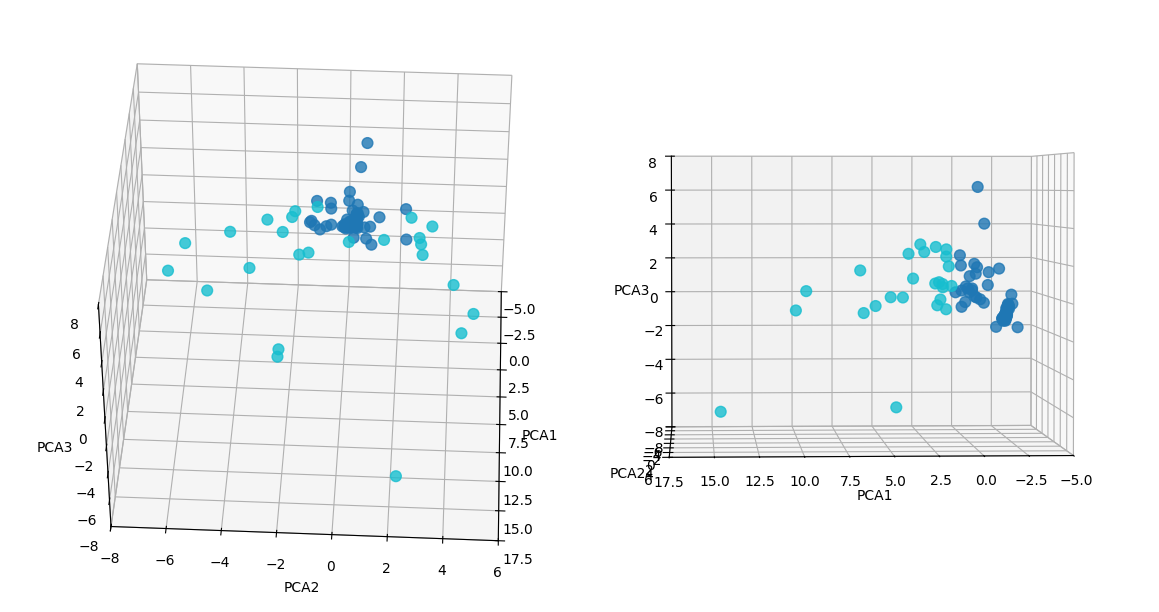

In [35]:
fig = plt.figure(figsize=(20, 10))

# Define the views you want
views = [
    (40, 3),
    (2, 87)
]

for i, (elev, azim) in enumerate(views, start=1):
    ax = fig.add_subplot(1, 3, i, projection="3d")

    ax.scatter(
        coords[0],
        coords[1],
        coords[2],
        c=cluster_labels,
        cmap='tab10',
        s=60,
        alpha=0.8
    )

    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.set_zlabel("PCA3")

    ax.set_xticks(ax.get_xticks())
    ax.set_yticks(ax.get_yticks())
    ax.set_zticks(ax.get_zticks())

    ax.view_init(elev=elev, azim=azim)

for ax in fig.axes:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 2, pos.height * 1.3])

plt.show()

In [36]:
sil_scores = defaultdict(dict)
chi_scores = defaultdict(dict)
dbi_scores = defaultdict(dict)

cols = feat_scaled.columns.tolist()

for size in range(2, 6):
    for subset in combinations(cols, size):
        subset = list(subset)
        feat_name = ",".join(subset)

        feat_sub = feat_scaled[subset].copy()

        for k in range(2, 6):
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(feat_sub)

            sil_scores[feat_name][k] = silhouette_score(feat_sub, labels)
            dbi_scores[feat_name][k] = davies_bouldin_score(feat_sub, labels)
            chi_scores[feat_name][k] = calinski_harabasz_score(feat_sub, labels)

weighted_score = defaultdict(dict)

for features in sil_scores:
    for k in sil_scores[features]:
        sil = sil_scores[features][k]
        dbi = dbi_scores[features][k]
        chi = chi_scores[features][k]

        dbi_inv = 1 / dbi

        weighted_score[features][k] = (w_sil * sil + w_db * dbi_inv + w_ch * chi)

rows = []

for features in sil_scores:
    for k in sil_scores[features]:
        rows.append({
            "Features": features,
            "k": k,
            "Silhouette": sil_scores[features][k],
            "Davies-Bouldin": dbi_scores[features][k],
            "Calinski-Harabasz": chi_scores[features][k],
            "Weighted Score": weighted_score[features][k]
        })

results_df = pd.DataFrame(rows)
results_df = results_df.sort_values("Weighted Score", ascending=False).reset_index(drop=True)
results_df.head(10)

Features  k  Silhouette  \
0                         night_day_ratio,has_Q_mean  3    0.982772   
1      capacitive_peak_power_morning,night_day_ratio  3    0.940930   
2                     avg_daily_peak,night_day_ratio  3    0.933142   
3  inductive_peak_power_evening,capacitive_peak_p...  2    0.942459   
4       inductive_peak_power_evening,night_day_ratio  3    0.931359   
5  avg_daily_peak,capacitive_peak_power_morning,n...  4    0.908961   
6      capacitive_peak_power_morning,night_day_ratio  2    0.939647   
7       avg_daily_peak,capacitive_peak_power_morning  3    0.920016   
8                avg_daily_peak,peak_power_afternoon  2    0.926735   
9  inductive_peak_power_evening,capacitive_peak_p...  3    0.919290   

   Davies-Bouldin  Calinski-Harabasz  Weighted Score  
0        0.007722      311424.415886       26.685359  
1        0.027139         531.343315        8.122334  
2        0.030302         479.167842        7.346746  
3        0.035223         464.844981        6.432016  
4        0.035805         478.767226        6.330917  
5        0.040328         286.238471        5.686488  
6        0.040666          89.044416        5.669867  
7        0.040774         274.451849        5.641077  
8        0.041596         187.761454        5.549571  
9        0.042499         367.246638        5.441370

In [37]:
best_row = results_df.iloc[0]
feat_best = feat_scaled[best_row["Features"].split(",")].copy()
#feat_best = feat_scaled[["inductive_peak_power_evening","capacitive_peak_power_morning"]].copy()
best_k = best_row["k"]
#best_k = 2

best_row

Features             night_day_ratio,has_Q_mean
k                                             3
Silhouette                             0.982772
Davies-Bouldin                         0.007722
Calinski-Harabasz                 311424.415886
Weighted Score                        26.685359
Name: 0, dtype: object

In [38]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(feat_best)

feat_clust2 = feat_best.copy()
feat_clust2.loc[:, "cluster"] = cluster_labels

#pca = PCA(n_components=2)
#coords = pca.fit_transform(feat_best)

#coords = coords.T

feat_clust2.sort_values("cluster")

night_day_ratio  has_Q_mean  cluster
CPE                                                       
PT0002000032936306KX        -0.028494   -1.080123        0
PT0002000032942455NH        -0.107462   -1.080123        0
PT0002000032959511HP        -0.116918   -1.080123        0
PT0002000032966446CC        -0.106829   -1.080123        0
PT0002000032968749YT        -0.113323   -1.080123        0
PT0002000032969229AC        -0.115714   -1.080123        0
PT0002000032976997LZ        -0.111287   -1.080123        0
PT0002000032990792KD        -0.107338   -1.080123        0
PT0002000032993611ME        -0.114311   -1.080123        0
PT0002000033016394FN        -0.113178   -1.080123        0
PT0002000033039837ZH        -0.113320   -1.080123        0
PT0002000033085062AW        -0.114003   -1.080123        0
PT0002000033171958DG        -0.112756   -1.080123        0
PT0002000033094187PL        -0.111849   -1.080123        0
PT0002000033186037TF        -0.113188   -1.080123        0
PT0002000033254603ZX        -0.110056   -1.080123        0
PT0002000066469574LZ        -0.108149   -1.080123        0
PT0002000053093191SV        -0.109843   -1.080123        0
PT0002000065256275YB        -0.115863   -1.080123        0
PT0002000065523872AA        -0.112948   -1.080123        0
PT0002000085641795MX        -0.111135   -1.080123        0
PT0002000106237165CF        -0.109241   -1.080123        0
PT0002000100742616GC        -0.107176   -1.080123        0
PT0002000089069203YG        -0.112098   -1.080123        0
PT0002000079901964CJ        -0.044116   -1.080123        0
PT0002000085555547GN        -0.087706   -1.080123        0
PT0002000084414998AX        -0.111476   -1.080123        0
PT0002000082592498EF        -0.110068   -1.080123        0
PT0002000069698702RB        -0.110918   -1.080123        0
PT0002000073598156DE        -0.116851   -1.080123        0
PT0002000069803182JW        -0.063197   -1.080123        0
PT0002000108315818YN        -0.085835   -1.080123        0
PT0002000117822355RM        -0.109905   -1.080123        0
PT0002000120320157HF        -0.107976   -1.080123        0
PT0002000131605602FL        -0.029994   -1.080123        0
PT0002000112171317NK        -0.053512   -1.080123        0
PT0002000112026362NN        -0.072785   -1.080123        0
PT0002000133505542CK        -0.107442   -1.080123        0
PT0002000133685986TF        -0.048308   -1.080123        0
PT0002000123801456QA        -0.113424   -1.080123        0
PT0002000107332489XW        -0.107636   -1.080123        0
PT0002000109942242HZ        -0.102419   -1.080123        0
PT0002000068859382XF        -0.113401    0.925820        1
PT0002000068857909SY        -0.111513    0.925820        1
PT0002000068857897ZV        -0.113243    0.925820        1
PT0002000068859325FL        -0.111983    0.925820        1
PT0002000068859187RL        -0.106643    0.925820        1
PT0002000073481266XH        -0.113823    0.925820        1
PT0002000078441876HB        -0.112731    0.925820        1
PT0002000078294957RQ        -0.115014    0.925820        1
PT0002000078233981HJ        -0.109756    0.925820        1
PT0002000078207354XC        -0.111828    0.925820        1
PT0002000077647404EM        -0.097247    0.925820        1
PT0002000068857099AR        -0.104892    0.925820        1
PT0002000068856952LS        -0.093650    0.925820        1
PT0002000068856906VS        -0.108107    0.925820        1
PT0002000068856872QG        -0.107540    0.925820        1
PT0002000068856781NM        -0.108335    0.925820        1
PT0002000068856655YV        -0.113866    0.925820        1
PT0002000068859597LS        -0.111718    0.925820        1
PT0002000068859393XH        -0.113035    0.925820        1
PT0002000071896778MT        -0.109237    0.925820        1
PT0002000073231742VK        -0.112487    0.925820        1
PT0002000033074862LZ        -0.114059    0.925820        1
PT0002000115700602GW        -0.114244    0.925820        1
PT0002000105483259QH        -0.104756    0.925820        1
PT00020001

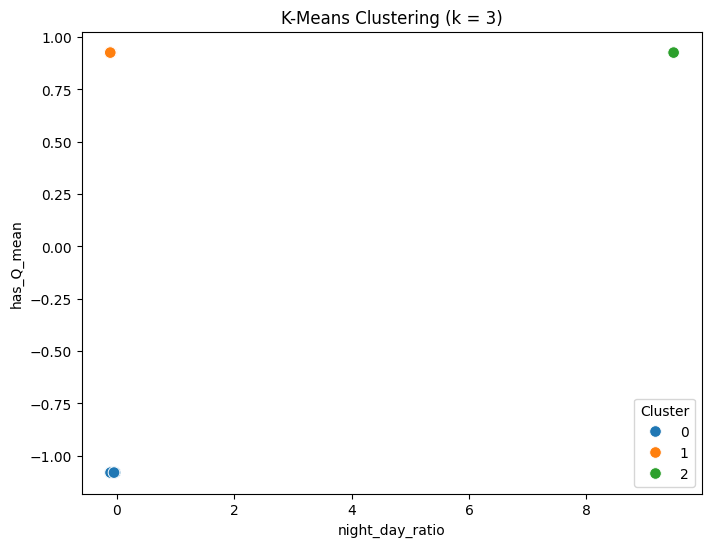

In [39]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=feat_best["night_day_ratio"],
    y=feat_best["has_Q_mean"],
    hue=cluster_labels,
    palette='tab10',
    s=70
)

plt.title(f"K-Means Clustering (k = {best_k})")
plt.xlabel("night_day_ratio")
plt.ylabel("has_Q_mean")
plt.legend(title="Cluster")
plt.show()

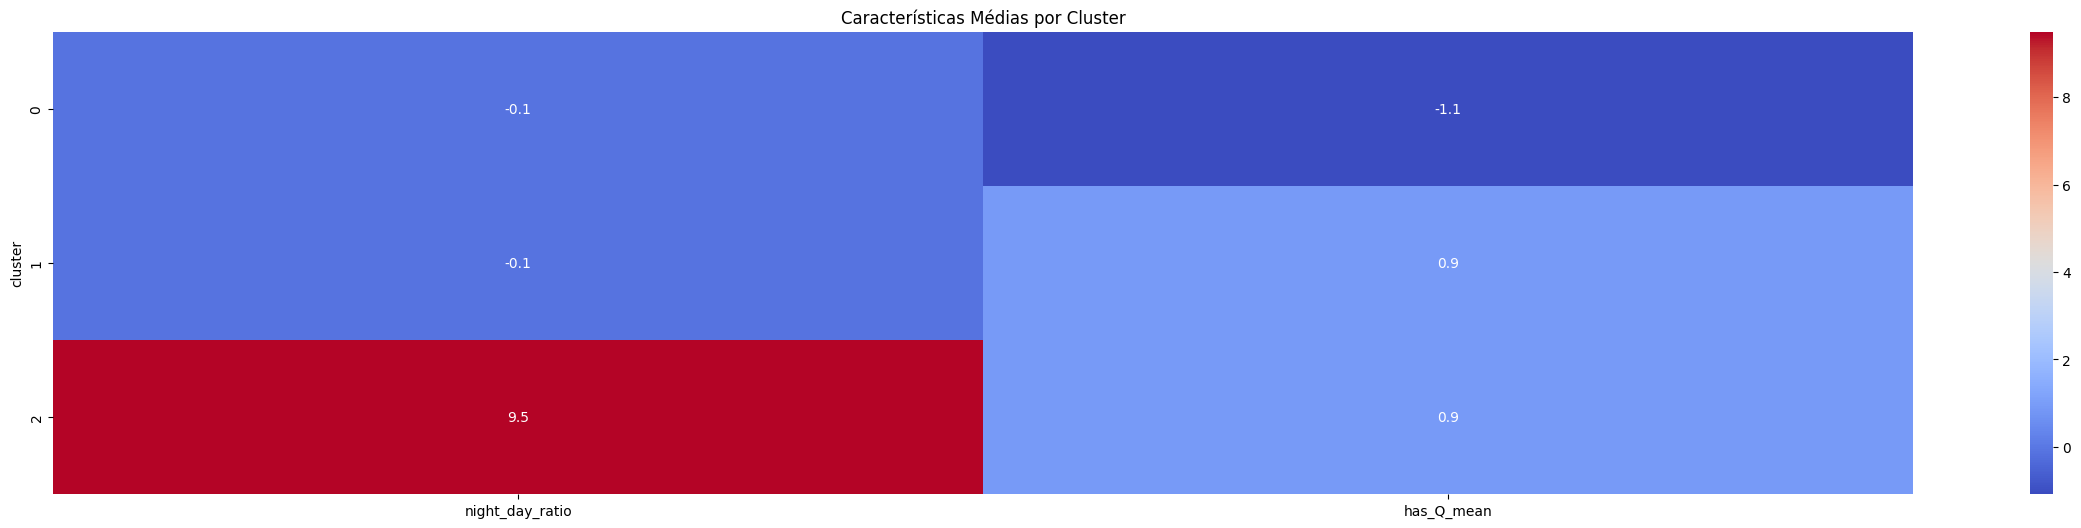

In [47]:
cluster_summary = feat_clust2.groupby("cluster").mean()
cluster_summary

plt.figure(figsize=(30,6))
sns.heatmap(cluster_summary, cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Características Médias por Cluster")
plt.show()

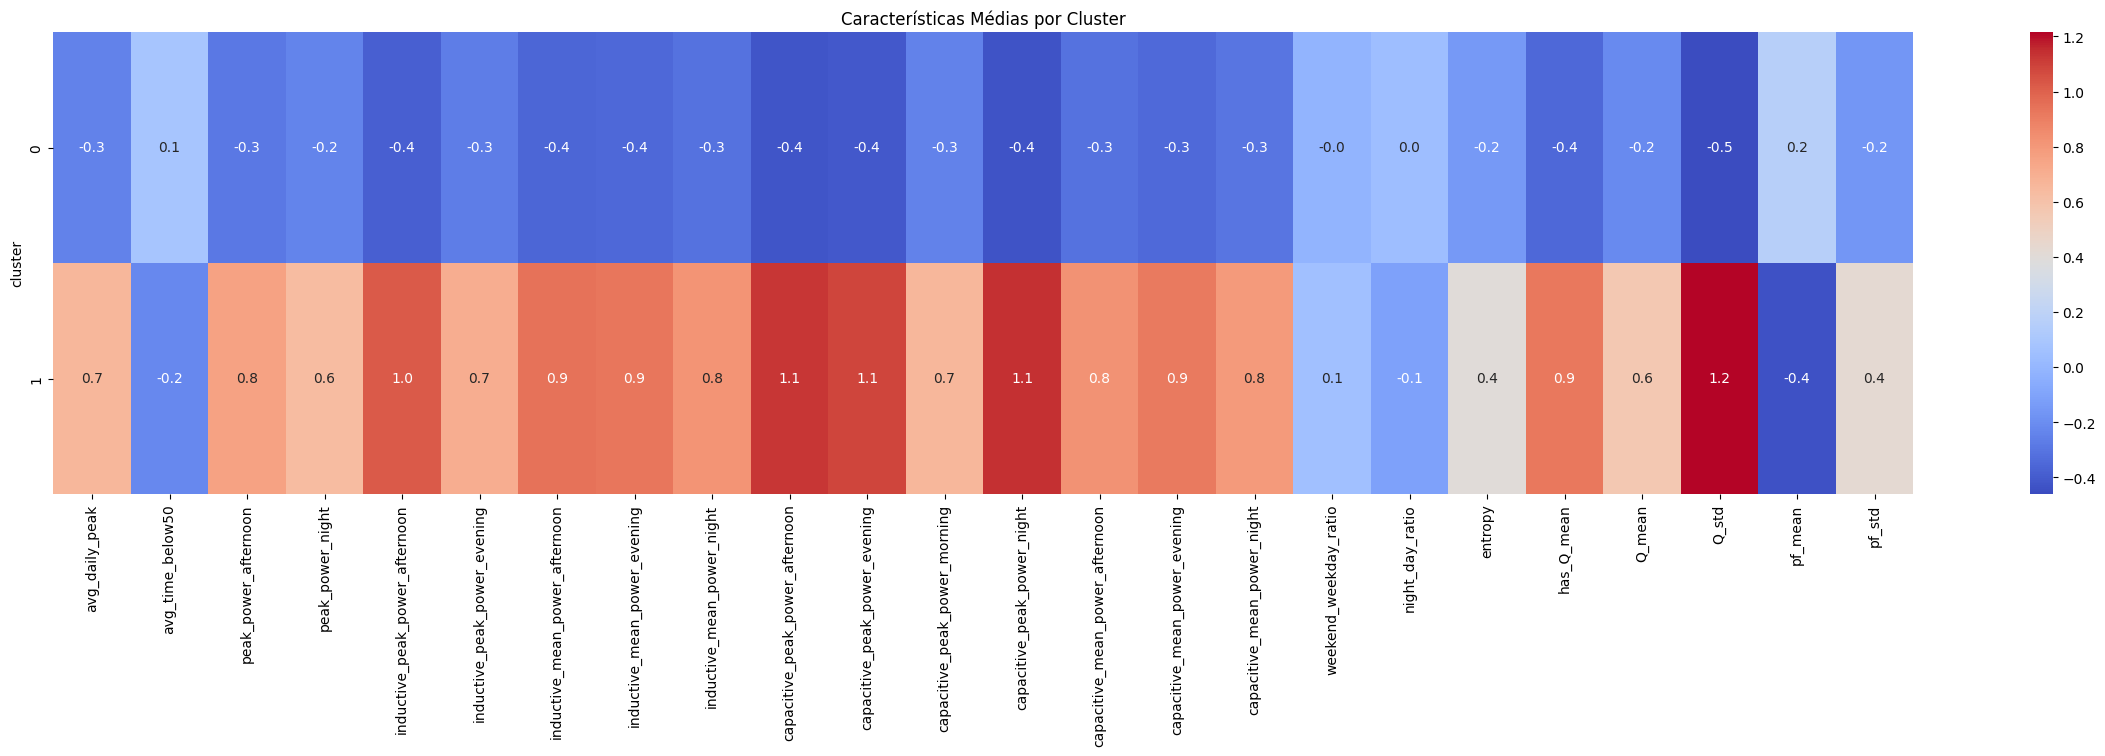

In [46]:
cluster_summary = feat_clust.groupby("cluster").mean()
cluster_summary

plt.figure(figsize=(30,6))
sns.heatmap(cluster_summary, cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Características Médias por Cluster")
plt.show()

In [42]:
cluster_sizes = feat_clust["cluster"].value_counts().sort_index()

summary_for_report = pd.DataFrame({
    "N_CPE": cluster_sizes,
    #"avg_daily_mean": cluster_summary["avg_daily_mean"],
    #"weekly_max": cluster_summary["weekly_max"],
    # "total_power": (
    #     cluster_summary["total_power_morning"] +
    #     cluster_summary["total_power_afternoon"] +
    #     cluster_summary["total_power_evening"] +
    #     cluster_summary["total_power_night"]
    # ),
    "weekend_weekday_ratio": cluster_summary["weekend_weekday_ratio"],
    "night_day_ratio": cluster_summary["night_day_ratio"],
})
summary_for_report

N_CPE  weekend_weekday_ratio  night_day_ratio
cluster                                               
0           66              -0.019715         0.041907
1           25               0.052048        -0.110635

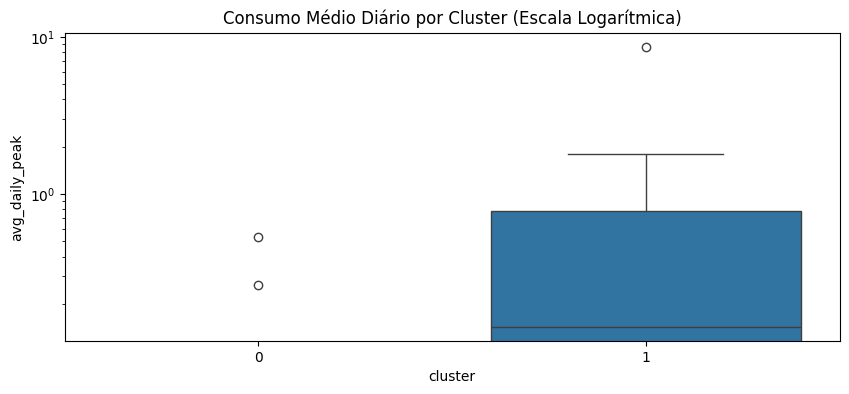

In [43]:
plt.figure(figsize=(10,4))
sns.boxplot(data=feat_clust, x="cluster", y="avg_daily_peak")
plt.yscale("log")
plt.title("Consumo Médio Diário por Cluster (Escala Logarítmica)")
plt.show()

In [44]:
from pandas.plotting import parallel_coordinates

# 1) Copiar o dataframe com clusters
df_plot = feat_clust.copy()          # feat_clust é o teu dataframe com as features + "cluster"

# 2) Se houver índice (CPE), trazer para coluna normal
df_plot = df_plot.reset_index()      # se o CPE estiver no índice

# 3) Garantir que TODOS os nomes de colunas são strings
df_plot.columns = df_plot.columns.map(str)

# 4) Garantir que "cluster" é string (classe categórica)
df_plot["cluster"] = df_plot["cluster"].astype(str)

# 5) (Opcional) escolher apenas algumas features para não ficar caótico
cols_features = [
    "avg_daily_mean",
    "weekly_max",
    "weekend_weekday_ratio",
    "night_day_ratio",
    "entropy",
]

# Construir dataframe final para o gráfico: classe + features
df_pc = df_plot[["cluster"] + cols_features]

# 6) Parallel coordinates
plt.figure(figsize=(10, 6))
parallel_coordinates(
    df_pc,
    class_column="cluster",
    colormap="viridis"
)
plt.xticks(rotation=45, ha="right")
plt.title("Perfis Médios Normalizados por Cluster")
plt.tight_layout()
plt.show()

KeyError: "['avg_daily_mean', 'weekly_max'] not in index"

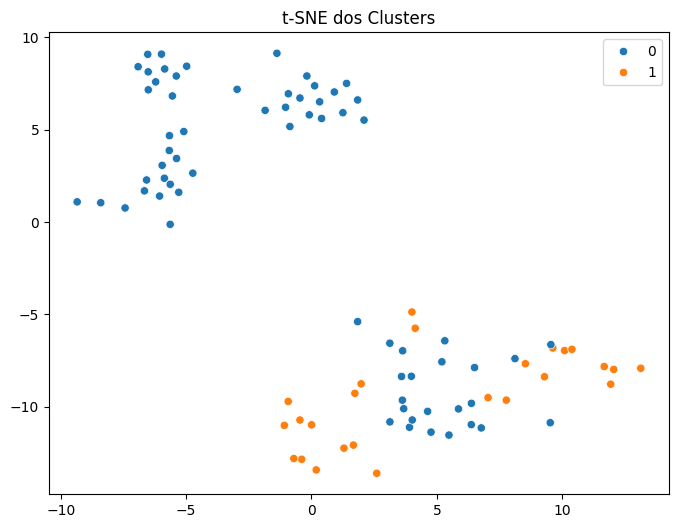

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=15, random_state=42)
coords_tsne = tsne.fit_transform(feat_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords_tsne[:,0], y=coords_tsne[:,1],
    hue=cluster_labels, palette="tab10"
)
plt.title("t-SNE dos Clusters")
plt.show()

O PCA permite representar os dados num espaço de 2 dimensões maximizando a variância, mas não preserva relações de proximidade entre os pontos.
Por isso, pode distorcer a estrutura real dos clusters.

Para avaliar se os clusters encontrados são realmente separados no espaço original, é preferível usar métodos não lineares como o t-SNE, que preservam vizinhanças e evidenciam agrupamentos naturais.

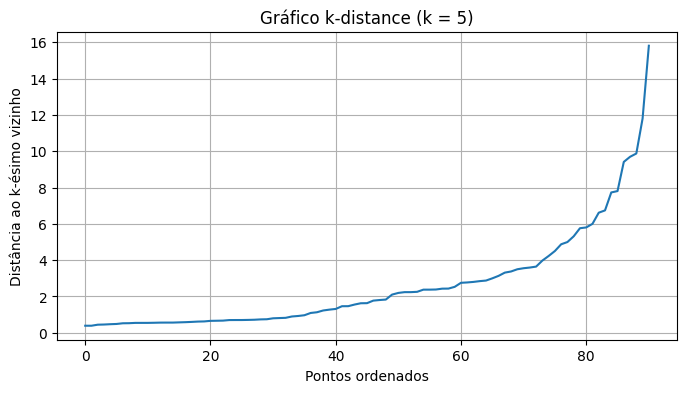

In [ ]:
from sklearn.neighbors import NearestNeighbors

min_samples = 5  # ponto de partida razoável

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(feat_scaled)
distances, indices = neighbors_fit.kneighbors(feat_scaled)

# Fica com a distância ao k-ésimo vizinho (última coluna)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8,4))
plt.plot(k_distances)
plt.title(f"Gráfico k-distance (k = {min_samples})")
plt.xlabel("Pontos ordenados")
plt.ylabel("Distância ao k-ésimo vizinho")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

eps_values = [0.3, 0.5, 0.7, 1.0, 1.5]        # adapta com base no gráfico
min_samples_values = [3, 5, 7, 9, 10]

results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(feat_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_frac = np.mean(labels == -1)

        # Silhouette só se houver pelo menos 2 clusters e nem tudo for ruído
        if n_clusters >= 2 and noise_frac < 0.95:
            mask = labels != -1
            sil = silhouette_score(feat_scaled[mask], labels[mask])
        else:
            sil = np.nan

        results.append({
            "eps": eps,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "noise_frac": noise_frac,
            "silhouette": sil
        })

results_df = pd.DataFrame(results)
results_df

eps  min_samples  n_clusters  noise_frac  silhouette
0   0.3            3           2    0.901099    0.859593
1   0.3            5           0    1.000000         NaN
2   0.3            7           0    1.000000         NaN
3   0.3            9           0    1.000000         NaN
4   0.3           10           0    1.000000         NaN
5   0.5            3           4    0.747253    0.557078
6   0.5            5           2    0.846154    0.742655
7   0.5            7           1    0.923077         NaN
8   0.5            9           0    1.000000         NaN
9   0.5           10           0    1.000000         NaN
10  0.7            3           3    0.604396    0.589358
11  0.7            5           3    0.626374    0.595164
12  0.7            7           3    0.670330    0.654580
13  0.7            9           2    0.791209    0.716457
14  0.7           10           1    0.890110         NaN
15  1.0            3           1    0.582418         NaN
16  1.0            5           1    0.582418         NaN
17  1.0            7           1    0.582418         NaN
18  1.0            9           3    0.582418    0.535329
19  1.0           10           3    0.582418    0.535329
20  1.5            3           3    0.406593    0.494649
21  1.5            5           2    0.483516    0.489694
22  1.5            7           2    0.494505    0.502531
23  1.5            9           1    0.582418         NaN
24  1.5           10           1    0.582418         NaN

In [ ]:
best_eps = 0.5
best_min_samples = 3

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_db = dbscan.fit_predict(feat_scaled)

# Copiar o dataframe de features (sem NaN) e adicionar o cluster DBSCAN
feat_db = feat_clust.copy()
feat_db = feat_db.reset_index()  # se o CPE estiver no índice
feat_db["cluster_dbscan"] = labels_db

# Ver quantos clusters + ruído
print("Labels únicos:", sorted(set(labels_db)))
print("N.º de clusters (sem ruído):", len(set(labels_db)) - (1 if -1 in labels_db else 0))
print("Percentagem de ruído:", np.mean(labels_db == -1))

Labels únicos: [-1, 0, 1, 2, 3]
N.º de clusters (sem ruído): 4
Percentagem de ruído: 0.7472527472527473


In [ ]:
pca = PCA(n_components=2)
coords = pca.fit_transform(feat_scaled)

tsne = TSNE(n_components=2, perplexity=15, random_state=42)
coords_tsne = tsne.fit_transform(feat_scaled)

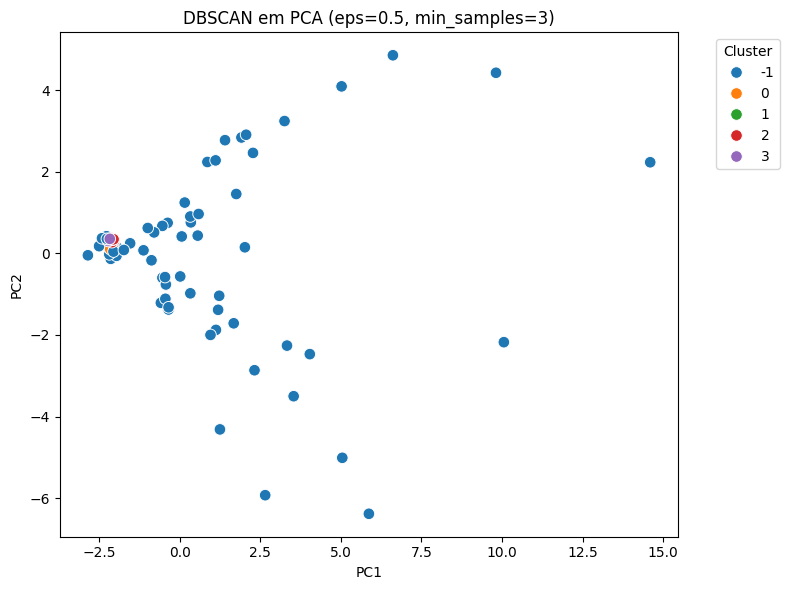

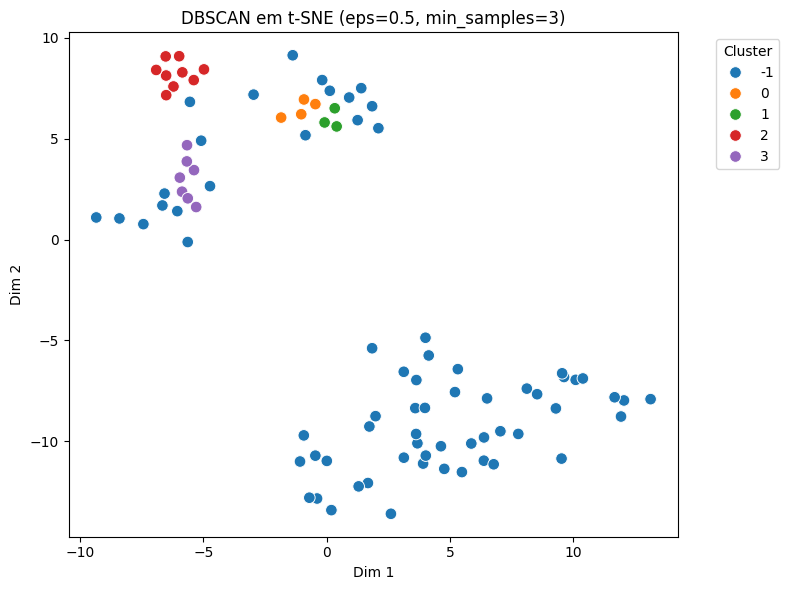

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords[:,0], y=coords[:,1],
    hue=labels_db,
    palette="tab10",
    s=70
)
plt.title(f"DBSCAN em PCA (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords_tsne[:,0], y=coords_tsne[:,1],
    hue=labels_db,
    palette="tab10",
    s=70
)
plt.title(f"DBSCAN em t-SNE (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
# Remover ruído
feat_db_valid = feat_db[feat_db["cluster_dbscan"] != -1]

# Selecionar só colunas numéricas
feat_db_valid_num = feat_db_valid.select_dtypes(include=["float", "int"]).copy()

# Reintroduzir a coluna cluster
feat_db_valid_num["cluster_dbscan"] = feat_db_valid["cluster_dbscan"].values

# Agora é seguro calcular a média
cluster_summary_db = (
    feat_db_valid_num
    .groupby("cluster_dbscan")
    .mean()
)

cluster_sizes_db = feat_db_valid["cluster_dbscan"].value_counts().sort_index()

summary_for_report_db = pd.DataFrame({
    "N_CPE": cluster_sizes_db,
    "avg_daily_mean": cluster_summary_db["avg_daily_mean"],
    "weekly_max": cluster_summary_db["weekly_max"],
    "total_power": (
        cluster_summary_db["total_power_morning"] +
        cluster_summary_db["total_power_afternoon"] +
        cluster_summary_db["total_power_evening"] +
        cluster_summary_db["total_power_night"]
    ),
    "weekend_weekday_ratio": cluster_summary_db["weekend_weekday_ratio"],
    "night_day_ratio": cluster_summary_db["night_day_ratio"],
})

summary_for_report_db


KeyError: 'avg_daily_mean'

### Supervised

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA



# Função para extrair série temporal limpa de um CPE
def get_series_for_cpe(prep_pdf, cpe):
    s = (
        prep_pdf[prep_pdf["CPE"] == cpe]
        .sort_values("tstamp")
        .set_index("tstamp")["PotActiva"]
    )
    # Garantir frequência fixa de 15 minutos
    s = s.asfreq("15min")
    # Tratar missing de forma simples
    s = s.interpolate(limit_direction="both")
    return s

# Função para partir em 70% / 30% temporal
def split_series_train_test(s, train_frac=0.7):
    n = len(s)
    cutoff = int(n * train_frac)
    train = s.iloc[:cutoff]
    test  = s.iloc[cutoff:]
    return train, test


In [ ]:
def baseline_week_before(train, test):
    # juntamos para ter índice contínuo
    full = pd.concat([train, test])
    
    # 1 semana = 96*7 passos de 15 min
    lag = 96 * 7
    
    # previsão = valor observado 1 semana antes
    baseline_full = full.shift(lag)
    
    # baseline apenas para a parte de teste
    baseline_test = baseline_full.loc[test.index]
    
    # limpar casos sem histórico suficiente
    mask = ~baseline_test.isna()
    y_true = test[mask]
    y_pred = baseline_test[mask]
    
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse, y_true, y_pred



=== CPE PT0002000078441876HB ===
Baseline (1 semana) - MAE=43.098, RMSE=60.869


C:\Users\João Oliveira\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3,1,3)(2,1,1,24) - MAE=93.518, RMSE=111.189


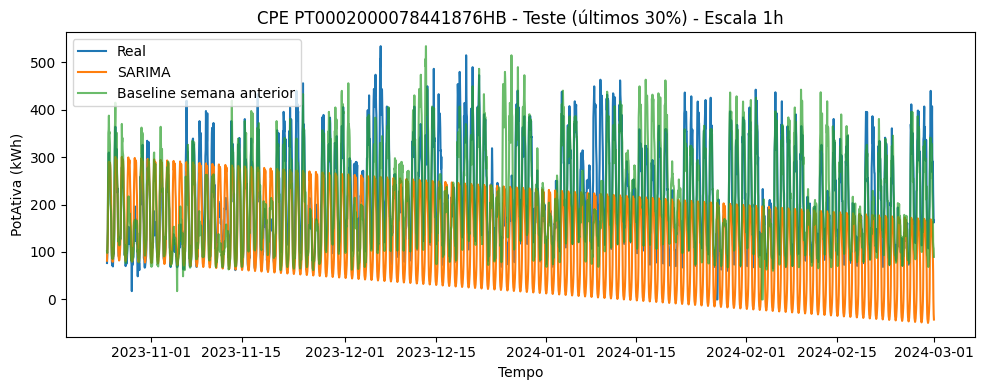

CPE  MAE_baseline  RMSE_baseline  MAE_sarima  RMSE_sarima
0  PT0002000078441876HB     43.097865      60.869068   93.517838    111.18934

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Função para extrair série temporal limpa de um CPE
def get_series_for_cpe(prep_pdf, cpe):
    s = (
        prep_pdf[prep_pdf["CPE"] == cpe]
        .sort_values("tstamp")
        .set_index("tstamp")["PotActiva"]
    )
    s = s.asfreq("15min")
    s = s.interpolate(limit_direction="both")
    return s

# Train/test split temporal
def split_series_train_test(s, train_frac=0.7):
    n = len(s)
    cutoff = int(n * train_frac)
    return s.iloc[:cutoff], s.iloc[cutoff:]

def baseline_week_before(series):
    """Baseline já após resample"""
    lag = 24 * 7   # 1 semana em dados de 1h
    shifted = series.shift(lag)
    mask = ~shifted.isna()
    return shifted[mask], series[mask]


results_arima = []
cpe_list = top3_list
cpe=top3_list[0]

print(f"\n=== CPE {cpe} ===")

# 1) Série original a 15 min
s = get_series_for_cpe(prep_pdf, cpe)
train_raw, test_raw = split_series_train_test(s, train_frac=0.7)

# 2) Converter tudo para 1h
train = train_raw.resample("1h").mean().interpolate()
test  = test_raw.resample("1h").mean().interpolate()

# 3) Baseline corretamente feita em 1h
y_pred_base, y_true_base = baseline_week_before(pd.concat([train, test]))    
y_pred_base = y_pred_base.loc[test.index]
y_true_base = y_true_base.loc[test.index]

mae_base = mean_absolute_error(y_true_base, y_pred_base)
rmse_base = sqrt(mean_squared_error(y_true_base, y_pred_base))
print(f"Baseline (1 semana) - MAE={mae_base:.3f}, RMSE={rmse_base:.3f}")

# 4) SARIMA correto com sazonalidade 24 (não 96)
model = SARIMAX(
    train,
    order=(3,1,3),
    seasonal_order=(2,1,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit(disp=False)

forecast = pd.Series(
    model_fit.forecast(len(test)),
    index=test.index
)

mae_sarima = mean_absolute_error(test, forecast)
rmse_sarima = sqrt(mean_squared_error(test, forecast))

print(f"SARIMA(3,1,3)(2,1,1,24) - MAE={mae_sarima:.3f}, RMSE={rmse_sarima:.3f}")

results_arima.append({
    "CPE": cpe,
    "MAE_baseline": mae_base,
    "RMSE_baseline": rmse_base,
    "MAE_sarima": mae_sarima,
    "RMSE_sarima": rmse_sarima
})

# 5) Gráfico alinhado (tudo a 1h)
plt.figure(figsize=(10,4))
plt.plot(test.index, test.values, label="Real")
plt.plot(forecast.index, forecast.values, label="SARIMA")
plt.plot(y_pred_base.index, y_pred_base.values, label="Baseline semana anterior", alpha=0.7)
plt.title(f"CPE {cpe} - Teste (últimos 30%) - Escala 1h")
plt.xlabel("Tempo")
plt.ylabel("PotAtiva (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

results_arima = pd.DataFrame(results_arima)
results_arima


In [ ]:
def compute_weekly_target(df, time_col="tstamp", power_col="PotActiva"):
    targets = []
    features = []
    cpes = []

    for cpe, g in df.groupby("CPE"):
        g = g.sort_values(time_col)
        g["week"] = g[time_col].dt.isocalendar().week
        g["year"] = g[time_col].dt.year

        weekly = g.groupby(["year", "week"])[power_col].mean()

        df_tmp = pd.DataFrame({
            "weekly_mean": weekly.values,
            "target_next": weekly.shift(-1).values
        }, index=weekly.index).dropna()

        if len(df_tmp) > 2:
            features += df_tmp["weekly_mean"].tolist()
            targets  += df_tmp["target_next"].tolist()
            cpes     += [cpe]*len(df_tmp)

    return pd.DataFrame({"CPE": cpes, "weekly_mean": features, "target": targets})


In [ ]:
df_week = compute_weekly_target(prep_pdf)

df_week = df_week.reset_index(drop=True)

X = df_week[["weekly_mean"]]
y = df_week["target"]




In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

# Normalizar TARGET
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

mae_rf  = mean_absolute_error(y_test, rf_pred)
rmse_rf = sqrt(mean_squared_error(y_test, rf_pred))

print("RANDOM FOREST:")
print(" MAE:", mae_rf)
print(" RMSE:", rmse_rf)


RANDOM FOREST:
 MAE: 1.4294350860804734
 RMSE: 4.154538900959515


In [ ]:
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import numpy as np

def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 0.4),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 3.0),
        "objective": "reg:squarederror",
        "random_state": 42,
    }

    # pipeline completa
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", xgb.XGBRegressor(**params))
    ])

    # treinar com y normalizado
    pipe.fit(X_train, y_train_scaled)

    # prever em escala normalizada
    pred_scaled = pipe.predict(X_test)

    # inverter para escala real
    pred = scaler_y.inverse_transform(pred_scaled.reshape(-1,1)).ravel()

    # MAE em escala original
    mae = mean_absolute_error(y_test, pred)
    return mae  


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=400)

print("Best parameters:")
print(study.best_params)


[I 2025-12-07 14:34:44,237] A new study created in memory with name: no-name-c063682a-aa1e-4c5c-8ae2-ab6d033eff71
[I 2025-12-07 14:34:44,489] Trial 0 finished with value: 1.3323676602105492 and parameters: {'n_estimators': 310, 'learning_rate': 0.013335248209574541, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.7843324834418169, 'colsample_bytree': 0.7153573556894408, 'gamma': 0.013963945663282696, 'reg_alpha': 0.854874991805232, 'reg_lambda': 1.9733756032775955}. Best is trial 0 with value: 1.3323676602105492.
[I 2025-12-07 14:34:44,638] Trial 1 finished with value: 1.2709949986446085 and parameters: {'n_estimators': 491, 'learning_rate': 0.14685382576667866, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9491803547066331, 'colsample_bytree': 0.6654886444912586, 'gamma': 0.022667068038498606, 'reg_alpha': 0.9509316282190237, 'reg_lambda': 2.7081263500654433}. Best is trial 1 with value: 1.2709949986446085.
[I 2025-12-07 14:34:44,814] Trial 2 finished with value: 1.31811

Best parameters:
{'n_estimators': 601, 'learning_rate': 0.052832924865477505, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7713554259893638, 'colsample_bytree': 0.708386045405261, 'gamma': 0.00012307832468759088, 'reg_alpha': 0.8000838143546917, 'reg_lambda': 2.5765841283966244}


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


xgb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", xgb.XGBRegressor(
        n_estimators=457,
        learning_rate=0.1912203519229329,
        max_depth=3,
        min_child_weight=1,
        subsample=0.8922026194019185,
        colsample_bytree=0.8323048176997015,
        gamma=4.694134886707043e-05,
        reg_alpha=0.10407604962268763,
        reg_lambda=1.2169752189256011,
        random_state=42,
        objective="reg:squarederror"
    ))
])

# Treinar com target já normalizado
xgb_pipe.fit(X_train, y_train_scaled)

# Previsão em escala normalizada
xgb_pred_scaled = xgb_pipe.predict(X_test)

# Voltar à escala original
xgb_pred = scaler_y.inverse_transform(xgb_pred_scaled.reshape(-1, 1)).ravel()

mae_xgb  = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = sqrt(mean_squared_error(y_test, xgb_pred))

print("\nXGBOOST with Imputer + Scaler + Pipeline:")
print(" MAE:", mae_xgb)
print(" RMSE:", rmse_xgb)



XGBOOST with Imputer + Scaler + Pipeline:
 MAE: 1.2723413328646884
 RMSE: 5.12130015254474


In [ ]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(16, 8),
    activation="relu",
    max_iter=2000,
    random_state=42,
    learning_rate_init=0.001
)

mlp.fit(X_train_scaled, y_train_scaled)

# Previsões em escala normalizada
mlp_pred_scaled = mlp.predict(X_test_scaled)

# Converter de volta para escala real
mlp_pred = scaler_y.inverse_transform(mlp_pred_scaled.reshape(-1,1)).ravel()



In [ ]:

# Baseline 1: prever sempre a média do y_train
baseline_mean_pred = np.full(len(y_test), y_train.mean())

mae_base_mean = mean_absolute_error(y_test, baseline_mean_pred)
rmse_base_mean = sqrt(mean_squared_error(y_test, baseline_mean_pred))


# Baseline 2: persistência semanal
# Usar o weekly_mean da mesma linha de teste (alinhamento por índice)
baseline_persist_pred = X.loc[y_test.index, "weekly_mean"].values


mae_base_pers = mean_absolute_error(y_test, baseline_persist_pred)
rmse_base_pers = sqrt(mean_squared_error(y_test, baseline_persist_pred))


# Tabela de resultados
results = pd.DataFrame({
    "Modelo": [
        "Baseline (média treino)",
        "Baseline (persistência semanal)",
        "Random Forest",
        "XGBoost",
        "MLP"
    ],
    "MAE": [
        mae_base_mean,
        mae_base_pers,
        mae_rf,
        mae_xgb,
        mean_absolute_error(y_test, mlp_pred)
    ],
    "RMSE": [
        rmse_base_mean,
        rmse_base_pers,
        rmse_rf,
        rmse_xgb,
        sqrt(mean_squared_error(y_test, mlp_pred))
    ]
})

results


Modelo       MAE       RMSE
0          Baseline (média treino)  8.919381  19.849357
1  Baseline (persistência semanal)  1.030526   3.129140
2                    Random Forest  1.429435   4.154539
3                          XGBoost  1.272341   5.121300
4                              MLP  1.128180   3.120661

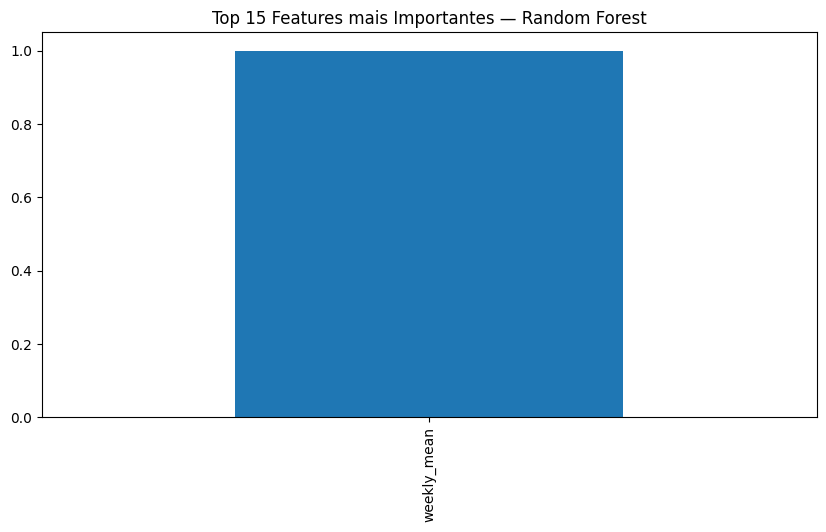

In [ ]:
rf_importances = pd.Series(rf.feature_importances_, index=X.columns)

plt.figure(figsize=(10,5))
rf_importances.sort_values(ascending=False).head(15).plot(kind='bar')
plt.title("Top 15 Features mais Importantes — Random Forest")
plt.show()


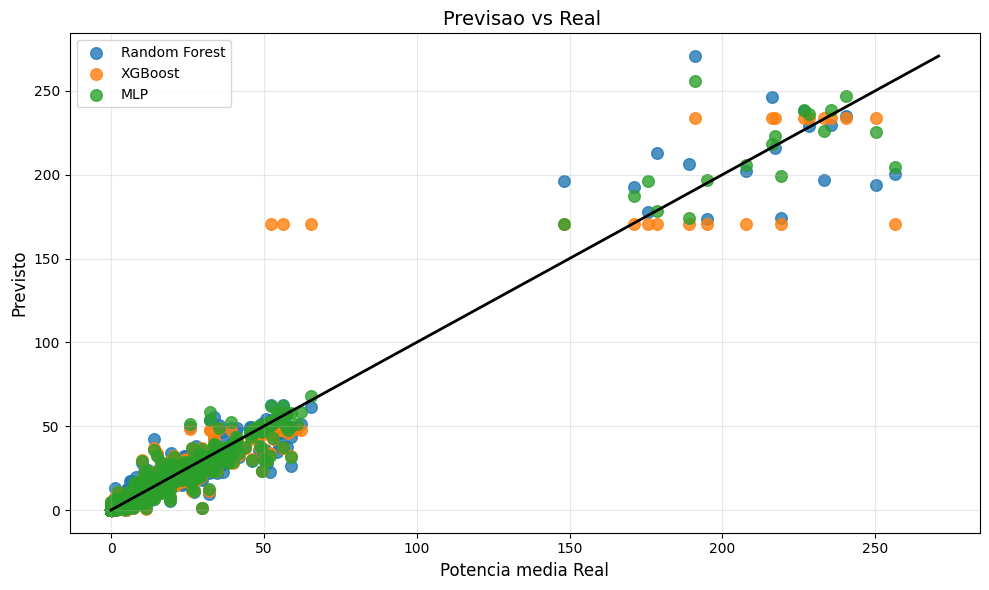

In [ ]:
plt.figure(figsize=(10,6))

min_v = min(y_test.min(), rf_pred.min(), xgb_pred.min(), mlp_pred.min())
max_v = max(y_test.max(), rf_pred.max(), xgb_pred.max(), mlp_pred.max())

plt.plot([min_v, max_v], [min_v, max_v], "k-", linewidth=2)

# Pontos dos modelos
plt.scatter(y_test, rf_pred,  s=70, label="Random Forest", alpha=0.8)
plt.scatter(y_test, xgb_pred, s=70, label="XGBoost",       alpha=0.8)
plt.scatter(y_test, mlp_pred, s=70, label="MLP",           alpha=0.8)

plt.xlabel("Potencia media Real", fontsize=12)
plt.ylabel("Previsto", fontsize=12)
plt.title("Previsao vs Real ", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
#        SUPERVISED — PREVISÃO SEMANAL MULTIVARIADA
# ============================================================

print("\n=== NOVA VERSÃO SUPERVISED — MULTIFEATURES ===\n")


# ============================================================
# 1. CONSTRUIR DATASET SEMANAL MULTIVARIADO
# ============================================================

def build_weekly_dataset(df):

    rows = []

    for cpe, g in df.groupby("CPE"):

        g = g.sort_values("tstamp")
        g["year"] = g["tstamp"].dt.year
        g["week"] = g["tstamp"].dt.isocalendar().week
        g["weekday"] = g["tstamp"].dt.weekday

        # weekly mean
        weekly = g.groupby(["year","week"])["PotActiva"].agg(
            weekly_mean="mean",
            weekly_max="max",
            weekly_std="std"
        )

        # weekday/weekend means
        weekpart = g.groupby(["year","week","weekday"])["PotActiva"].mean().reset_index()
        weekpart["is_weekend"] = weekpart["weekday"].isin([5,6]).astype(int)

        ww = weekpart.groupby(["year","week","is_weekend"])["PotActiva"].mean().unstack(fill_value=0)
        ww.columns = ["weekday_mean", "weekend_mean"]

        weekly = weekly.join(ww, how="left")

        # weekend/weekday ratio
        weekly["weekend_ratio"] = weekly["weekend_mean"] / (weekly["weekday_mean"] + 1e-6)

        # entropy semanal
        def ent(x):
            p = x[x > 0] / x.sum()
            return -(p * np.log(p+1e-9)).sum()

        ent_week = g.groupby(["year","week"])["PotActiva"].apply(ent)
        weekly["entropy_week"] = ent_week

        # shift target (next week)
        weekly["target_next"] = weekly["weekly_mean"].shift(-1)

        # atribuir CPE
        weekly["CPE"] = cpe

        rows.append(weekly)

    df_week = pd.concat(rows).reset_index()[[
        "CPE","year","week",
        "weekly_mean","weekly_max","weekly_std",
        "weekday_mean","weekend_mean","weekend_ratio",
        "entropy_week","target_next"
    ]]

    df_week = df_week.dropna(subset=["target_next"])
    return df_week


df_weekly = build_weekly_dataset(prep_pdf)
print("Shape do dataset semanal:", df_weekly.shape)
df_weekly.head()



=== NOVA VERSÃO SUPERVISED — MULTIFEATURES ===

Shape do dataset semanal: (8937, 11)


CPE  year  week  weekly_mean  weekly_max  weekly_std  \
0  PT0002000032936306KX  2024     1     3.321667       5.552    2.637747   
1  PT0002000032936306KX  2024     9     1.896404       5.480    2.564915   
2  PT0002000032936306KX  2024    10     2.787131       5.516    2.676819   
3  PT0002000032936306KX  2024    11     2.714899       5.524    2.677644   
4  PT0002000032936306KX  2024    12     2.651565       5.504    2.671130   

   weekday_mean  weekend_mean  weekend_ratio  entropy_week  target_next  
0      3.321667      0.000000   0.000000e+00      4.771001     1.896404  
1      0.000000      2.834729   2.834729e+06      4.627121     2.787131  
2      2.797508      2.761187   9.870164e-01      5.859670     2.714899  
3      2.724992      2.689667   9.870363e-01      5.836289     2.651565  
4      2.663658      2.621333   9.841098e-01      5.813870     2.548647

In [ ]:
# ==============================================
# 2. Preparação dos dados para treino
# ==============================================

features = [
    "weekly_mean",
    "weekly_max",
    "weekly_std",
    "weekday_mean",
    "weekend_mean",
    "weekend_ratio",
    "entropy_week"
]

X = df_weekly[features]
y = df_weekly["target_next"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()



Baseline:
 MAE  = 8.919380986224555
 RMSE = 19.849356830179502

Random Forest:
 MAE = 1.1169253014595604
 RMSE = 3.29163586386128

XGBoost:
 MAE = 1.0828262162428466
 RMSE = 3.125994572687603


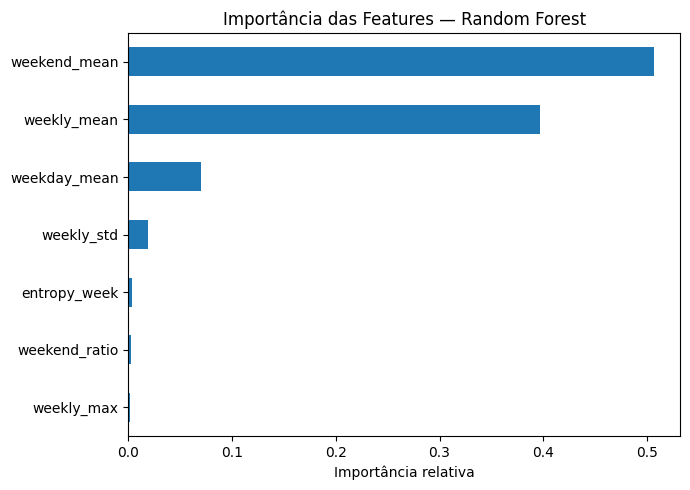


MLP (com imputação):
 MAE = 1.038082473142512
 RMSE = 3.041853689638246


Modelo       MAE       RMSE
0       Baseline  8.919381  19.849357
1  Random Forest  1.116925   3.291636
2        XGBoost  1.082826   3.125995
3            MLP  1.038082   3.041854

In [ ]:
# ============================================================
# 3. BASELINE
# ============================================================

baseline_pred = np.full(len(y_test), y_train.mean())

mae_base = mean_absolute_error(y_test, baseline_pred)
rmse_base = sqrt(mean_squared_error(y_test, baseline_pred))

print("\nBaseline:")
print(" MAE  =", mae_base)
print(" RMSE =", rmse_base)


# ============================================================
# 4. RANDOM FOREST
# ============================================================

rf = RandomForestRegressor(n_estimators=400, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, rf_pred)
rmse_rf = sqrt(mean_squared_error(y_test, rf_pred))

print("\nRandom Forest:")
print(" MAE =", mae_rf)
print(" RMSE =", rmse_rf)


# ============================================================
# 5. XGBOOST
# ============================================================

xgb_model = xgb.XGBRegressor(
    n_estimators=400,
    learning_rate=0.08,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42,
)

xgb_model.fit(X_train_scaled, y_train_scaled)

xgb_pred_scaled = xgb_model.predict(X_test_scaled)
xgb_pred = scaler_y.inverse_transform(xgb_pred_scaled.reshape(-1,1)).ravel()

mae_xgb = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = sqrt(mean_squared_error(y_test, xgb_pred))

print("\nXGBoost:")
print(" MAE =", mae_xgb)
print(" RMSE =", rmse_xgb)


# ============================================================
# 6. MLP
# ============================================================

mlp_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(32,16),
        activation="relu",
        max_iter=2000,
        learning_rate_init=0.001,
        random_state=42
    ))
])

mlp_pipeline.fit(X_train, y_train)

mlp_pred = mlp_pipeline.predict(X_test)

mae_mlp = mean_absolute_error(y_test, mlp_pred)
rmse_mlp = sqrt(mean_squared_error(y_test, mlp_pred))

importances = pd.Series(rf.feature_importances_, index=features)
importances.sort_values(ascending=True).plot(kind="barh", figsize=(7,5))
plt.title("Importância das Features — Random Forest")
plt.xlabel("Importância relativa")
plt.tight_layout()
plt.show()


print("\nMLP (com imputação):")
print(" MAE =", mae_mlp)
print(" RMSE =", rmse_mlp)


# ============================================================
# 7. TABELA FINAL
# ============================================================

results = pd.DataFrame({
    "Modelo": ["Baseline", "Random Forest", "XGBoost", "MLP"],
    "MAE":   [mae_base, mae_rf, mae_xgb, mae_mlp],
    "RMSE":  [rmse_base, rmse_rf, rmse_xgb, rmse_mlp]
})

results


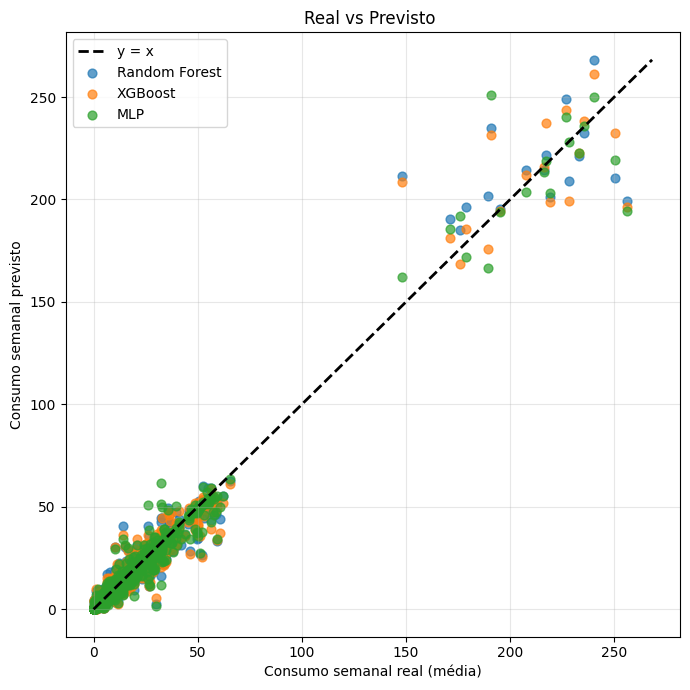

In [ ]:
# === Gráfico y_real vs y_pred para os três modelos ===

plt.figure(figsize=(7,7))

min_v = min(y_test.min(), rf_pred.min(), xgb_pred.min(), mlp_pred.min())
max_v = max(y_test.max(), rf_pred.max(), xgb_pred.max(), mlp_pred.max())

# Linha de perfeição
plt.plot([min_v, max_v], [min_v, max_v], "k--", linewidth=2, label="y = x")

plt.scatter(y_test, rf_pred,  s=40, alpha=0.7, label="Random Forest")
plt.scatter(y_test, xgb_pred, s=40, alpha=0.7, label="XGBoost")
plt.scatter(y_test, mlp_pred, s=40, alpha=0.7, label="MLP")

plt.xlabel("Consumo semanal real (média)")
plt.ylabel("Consumo semanal previsto")
plt.title("Real vs Previsto ")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
